# Initialization

Import needed libraries.

In [1]:
import numpy as np
import itertools
import pandas as pd

from sklearn.metrics import roc_curve, roc_auc_score

import os
import pickle
import contextlib

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib_venn import venn3
import seaborn as sns
%matplotlib inline

import promisys.bmp as psb
import promisys.combinatorial_addressing as psc
import promisys.mutual_information as psi
import promisys.utilities as psu

Configure select parameters for plotting.

In [2]:
font_kwargs = {'family': 'sans-serif',
               'sans-serif': 'Arial',
               'size': 10}
plt.rc('font', **font_kwargs)
mathtext_kwargs = {'fontset': 'custom',
                   'bf': 'Arial:bold',
                   'cal': 'Arial:italic',
                   'it': 'Arial:italic',
                   'rm': 'Arial'}
plt.rc('mathtext', **mathtext_kwargs)
savefig_kwargs = {'dpi': 300,
                  'bbox_inches': 'tight',
                  'transparent': True}
plt.rc('pdf', fonttype=42)

labelsize, ticksize = 10, 9

### Specify output settings.
Use `save_fig = True` to save resulting plots to directory specified in `out_dir`.

In [3]:
save_fig = False
out_dir = '.'

Define utility functions for analyzing and visualizing results.

In [4]:
L_min, L_max, L_res_sim = 0, 3, 10

def set_minor_loc(axis='both', ax=None):
    if ax is None:
        ax = plt.gca()
    minor_loc = plt.LogLocator(subs='all', numticks=10)
    if axis == 'x' or axis == 'both':
        ax.xaxis.set_minor_locator(minor_loc)
    if axis == 'y' or axis == 'both':
        ax.yaxis.set_minor_locator(minor_loc)

def label_plot(xticks, xticklabels, xlabel,
               yticks, yticklabels, ylabel,
               ticksize=ticksize, labelsize=labelsize,
               title=None, titlesize=labelsize):
    plt.xticks(ticks=xticks, labels=xticklabels, fontsize=ticksize)
    plt.yticks(ticks=yticks, labels=yticklabels, fontsize=ticksize)
    plt.xlabel(xlabel, fontsize=labelsize)
    plt.ylabel(ylabel, fontsize=labelsize)
    if title:
        plt.title(title, fontsize=titlesize)

def plot_responses(model_size, R, K, e, L_opt, L_sim, order,
                   axes=None, out_file=None):
    # Initialize plots and specify labels
    b = len(R)
    if axes is None:
        fig, axes = plt.subplots(1, b, figsize=(1*b, 1.25))
    ticks = 10 ** np.arange(L_min, L_max + 1)
    ticklabels = [r'$10^{{{:g}}}$'.format(l) for l in range(L_min, L_max + 1)]
    
    # Plot responses
    psu.plot_responses(model_size, R=R, K=K, e=e, L=L_sim,
                       L_min=L_min, L_max=L_max, L_res=L_res_sim,
                       axes=axes,
                       xticks=ticks, xlabels=ticklabels,
                       yticks=ticks, ylabels=ticklabels)
    
    # Plot ligand combinations corresponding to orthogonal channels
    inds = np.where(order)[0]
    L_plot = 10 ** 1.5 * L_opt[inds]
    psu.plot_combinations(L_plot, axes=axes,
                          marker_on='o', mec_on='r', mew_on=1,
                          mfc_on='None', ms_on=10,
                          marker_off='o', mec_off='r', mew_off=1,
                          mfc_off='None', ms_off=10)
    
    # Label plots
    for j in range(b):
        set_minor_loc(ax=axes[j])
        axes[j].tick_params(axis='both', which='both', labelsize=ticksize)
        axes[j].set_xlabel('Ligand 1', fontsize=labelsize)
        if j == 0:
            axes[j].set_ylabel('Ligand 2', fontsize=labelsize)
        else:
            axes[j].yaxis.set_minor_formatter(NullFormatter())
    
    if out_file is not None:
        plt.savefig(out_file, **savefig_kwargs)

def plot_matrix(S, fignum=1, figsize=(1.75, 1.75), out_file=None):
    # Plot crosstalk matrix
    if fignum > 0:
        plt.figure(num=fignum, figsize=figsize)
    plt.matshow(S, fignum=fignum, vmin=0, vmax=1)
    plt.xticks(np.arange(len(S.T)),
               [chr(ord('A') + i) for i in np.arange(len(S.T))],
               fontsize=ticksize)
    plt.tick_params('x', bottom=False)
    plt.xlabel('Cell Type', fontsize=labelsize)
    plt.gca().xaxis.set_label_position('top')
    plt.yticks(np.arange(len(S)), np.arange(len(S)) + 1, fontsize=ticksize)
    plt.ylabel('Ligand Word', fontsize=labelsize)
    
    # Generate colorbar
    ticks = np.arange(0, 1.01, 0.5)
    cb = plt.colorbar(fraction=0.045, ticks=ticks, orientation='horizontal')
    cb.ax.set_xticklabels(ticks, fontsize=ticksize, rotation=0)
    cb.set_label('Pathway Activity\n(Normalized)',
                 fontsize=labelsize, rotation=0, labelpad=2)

    if out_file is not None:
        plt.savefig(out_file, **savefig_kwargs)

# Analysis of model

## Figure S1

### Visualize response archetypes.

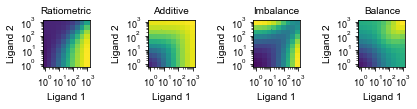

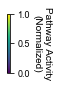

In [5]:
model_size = (2, 2, 2)
low, high = 0.1, 1

# Specify parameters for ratiometric response
rat_K = np.array([high, high, high, high, high, high, high, high])
rat_e = np.array([high, high, high, high, low, low, low, low])
rat_R = np.array([[1, 1, 1, 1]]) / 10 ** 1.5

# Specify parameters for additive response
add_K = np.array([high, high, high, high, high, high, high, high])
add_e = np.array([high, high, high, high, high, high, high, high])
add_R = np.array([[1, 1, 1, 1]]) / 10 ** 1.5

# Specify parameters for imbalance response
imb_K = np.array([high, low, high, low, low, high, low, high])
imb_e = np.array([low, high, low, high, high, low, high, low])
imb_R = np.array([[1, 1, 1, 1]]) / 10 ** 1.5

# Specify parameters for balance response
bal_K = np.array([high, low, high, low, low, high, low, high])
bal_e = np.array([high, low, high, low, low, high, low, high])
bal_R = np.array([[1, 1, 1, 1]]) / 10 ** 1.5

K = [rat_K, add_K, imb_K, bal_K]
e = [rat_e, add_e, imb_e, bal_e]
R = [rat_R, add_R, imb_R, bal_R]
n_archetypes = len(R)

fig, axes = plt.subplots(1, n_archetypes, figsize=(6, 1.5))
L_min, L_max, L_res_sim = 0, 3, 10
ticks = 10 ** np.arange(L_min, L_max + 1)
ticklabels = [r'$10^{{{:g}}}$'.format(l) for l in range(L_min, L_max + 1)]
titles = ['Ratiometric', 'Additive', 'Imbalance', 'Balance']

for i in range(n_archetypes):
    # Plot archetypal response
    psu.plot_responses(model_size, R=R[i], K=K[i], e=e[i],
                       L_min=L_min, L_max=L_max, L_res=L_res_sim,
                       axes=axes[i])
    
    # Label plot
    plt.sca(axes[i])
    set_minor_loc(ax=axes[i])
    label_plot(ticks, ticklabels, 'Ligand 1',
               ticks, ticklabels, 'Ligand 2', title=titles[i])
plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'FigureS1.pdf'), **savefig_kwargs)

# Plot colorbar
fig, axis = plt.subplots(1, 1, figsize=(1.25, 1.25))
im = axis.imshow(np.array([[0, 1]]), cmap='viridis', vmin=0, vmax=1)
axis.set_visible(False)
cb = plt.colorbar(im, ax=axis, ticks=[0, 0.5, 1])
cb.ax.tick_params(labelsize=ticksize)
cb.set_label('Pathway Activity\n(Normalized)', fontsize=labelsize,
             rotation=-90, labelpad=22)
plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'FigureS1_colorbar.pdf'),
                **savefig_kwargs)

# Analysis of orthogonal addressing

### Read in results for orthogonal addressing in one-to-one architecture.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [6]:
data_dir = os.path.join('..', 'Data')
data_file = 'Figure2-3_one-to-one.pkl'

# Read in results for orthogonal addressing in one-to-one system
with open(os.path.join(data_dir, data_file), 'rb') as f:
    n, c_all, L_all, R_all, K_all, e_all, disting_all = pickle.load(f)

### Read in results for orthogonal addressing in promiscuous architecture.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [7]:
data_dir = os.path.join('..', 'Data')
data_file = 'Figure2-3_orthogonal-addressing.pkl'

# Specify key parameters for ligand titration
L_min, L_max, L_res = 0, 3, 3
L_sim = psb.titrate_ligand(nL=2, L_min=-1.5, L_max=1.5, n_conc=10)

# Read in results for orthogonal addressing in promiscuous system
with open(os.path.join(data_dir, data_file), 'rb') as f:
    L, all_models, all_params, all_errs, all_configs, all_orders, all_chis = \
        pickle.load(f)

## Figure 2

Process data (Figures 2 and S2) and identify example 3-channel addressing scheme.

In [8]:
# Extract results for (2, 2, 2) model
m = 0
model_size = all_models[m]
params_all, errs_all, configs_all, orders_all, chis_all = \
    all_params[m], all_errs[m], all_configs[m], all_orders[m], all_chis[m]

# Extract best result for each addressing scheme
orders = [[] for i in range(len(configs_all))]
params = [[] for i in range(len(configs_all))]
chis = np.inf * np.ones(len(configs_all))
for config_i in range(len(configs_all)):
    if chis_all[config_i]:
        # Filter out parameter sets of all 0s
        inds = [ind for ind, param in enumerate(params_all[config_i])
                if not np.isclose(np.sum(param), 0)]
        orders_filt = [orders_all[config_i][ind] for ind in inds]
        params_filt = [params_all[config_i][ind] for ind in inds]
        chis_filt = [chis_all[config_i][ind] for ind in inds]
        
        # Find minimum crosstalk (maximum distinguishability)
        opt_i = np.argmin(chis_filt)
        orders[config_i] = orders_filt[opt_i]
        params[config_i] = params_filt[opt_i]
        chis[config_i] = chis_filt[opt_i]

# Analyze addressing schemes by numbers of channels
inds_channels = psu.index_configs_by_channels(configs_all)

# Extract example for 3 channels
b = 3
inds_b = inds_channels[b]
n_b = len(inds_b)
inds_b_sort = np.argsort(chis[inds_b])
ind_ex = inds_b[inds_b_sort[0]]

### Illustrate optimization approach with selected example.

K: [4.03500015e-03 9.99081586e-01 1.47187709e-01 4.06384471e-25
 9.97845906e-01 1.21203338e-05 4.08877424e-25 9.97017841e-01]
e: [9.99225863e-01 6.65566997e-28 1.08413001e-22 3.15131944e-07
 2.80064270e-18 6.02359133e-01 2.03419636e-02 3.00705303e-18]
K (thresholded): [False  True False False  True False False  True]
e (thresholded): [ True False False False False  True False False]


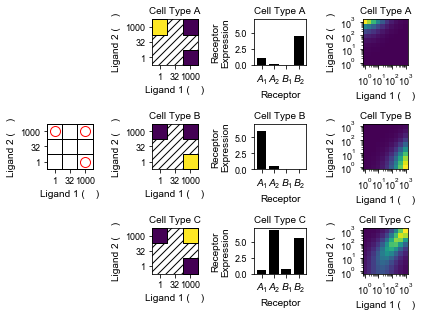

In [9]:
# Initialize plots and specify labels
fig, axes = plt.subplots(b, 4, figsize=(6, 1.5 * b))
ticks_t = [1, 32, 1000]
ticks_r = 10 ** np.arange(L_min, L_max + 1)
ticklabels_r = [r'$10^{{{:g}}}$'.format(l) for l in range(L_min, L_max + 1)]
xlabel = 'Ligand 1 (    )'
ylabel = 'Ligand 2 (    )'

# Plot target and ligand combinations corresponding to orthogonal channels
plt.sca(axes[1, 0])
psu.plot_targets(np.ones(len(L)).astype(int),
                 L_min=L_min, L_max=L_max, L_res=L_res,
                 axes=axes[1, 0],
                 cmap='Greys_r', compact=True)
inds = np.where(orders[ind_ex])[0]
L_plot = 10 ** 1.5 * L[inds]
axes[1, 0].plot(L_plot[:, 0], L_plot[:, 1], 'o',
                mec='r', mew=1, mfc='None', ms=10)
label_plot(ticks_t, ticks_t, xlabel, ticks_t, ticks_t, ylabel)
axes[0, 0].axis('off')
axes[2, 0].axis('off')

# Plot targeted responses
psu.plot_targets(orders[ind_ex],
                 L_min=L_min, L_max=L_max, L_res=L_res,
                 axes=axes[:, 1])

# Plot receptor profiles
R, K, e = psu.unpack_params(params[ind_ex], model_size)
psu.plot_receptors(model_size, R, axes=axes[:, 2])

# Print actual and thresholded parameter values
print('K:', K)
print('e:', e)
print('K (thresholded):', K > 0.5)
print('e (thresholded):', e > 0.5)

# Plot simulated responses
psu.plot_responses(model_size, L=L_sim, R=R, K=K, e=e,
                   L_min=L_min, L_max=L_max, L_res=L_res_sim,
                   axes=axes[:, 3])

# Label plots
for i in range(b):
    title = 'Cell Type ' + chr(ord('A') + i)
    plt.sca(axes[i, 1])
    plt.tick_params(axis='both', labelbottom=True, labelleft=True)
    label_plot(ticks_t, ticks_t, xlabel,
               ticks_t, ticks_t, ylabel, title=title)
    
    plt.sca(axes[i, 2])
    plt.tick_params(axis='both', labelbottom=True, labelleft=True)
    plt.locator_params(axis='y', nbins=3)
    plt.yticks(fontsize=ticksize)
    plt.ylabel('Receptor\nExpression', fontsize=labelsize)
    plt.title(title, fontsize=labelsize)
    
    plt.sca(axes[i, 3])
    plt.tick_params(axis='both', labelbottom=True, labelleft=True)
    set_minor_loc(ax=axes[i, 3])
    label_plot(ticks_r, ticklabels_r, xlabel,
               ticks_r, ticklabels_r, ylabel, title=title)

plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure2B.pdf'), **savefig_kwargs)

### Compute corresponding crosstalk matrix.

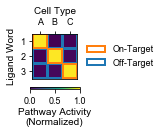

In [10]:
# Plot crosstalk matrix
plt.figure(num=1, figsize=(1, 1))
S = psb.sim_S_LAB(model_size, L,
                  R, K, e, norm=True)
plt.matshow(S.T[np.where(orders[ind_ex])[0]], fignum=1, vmin=0)
ax = plt.gca()

# Annotate on-target and off-target activities
for i in range(b):
    for j in range(b):
        if i == j:
            kwargs = {'color': 'C1', 'zorder': 2}
        else:
            kwargs = {'color': 'C0', 'zorder': 1}
        v = 0.47
        rect = plt.Rectangle((i - v, j - v), 2 * v, 2 * v,
                             **kwargs, fill=False, lw=2)
        ax.add_patch(rect)
plt.legend(['On-Target', 'Off-Target'], fontsize=ticksize,
           frameon=False, loc='center left', bbox_to_anchor=(1.05, 0.5))

# Label plot
plt.xticks(np.arange(len(S)), [chr(ord('A') + i) for i in np.arange(len(S))],
           fontsize=ticksize)
plt.tick_params('x', bottom=False)
plt.xlabel('Cell Type', fontsize=labelsize)
ax.xaxis.set_label_position('top')
plt.yticks(np.arange(len(S)), np.arange(len(S)) + 1, fontsize=ticksize)
plt.ylabel('Ligand Word', fontsize=labelsize)

# Generate colorbar
ticks = np.arange(0, 1.01, 0.5)
cb = plt.colorbar(fraction=0.045, ticks=ticks, orientation='horizontal')
cb.ax.set_xticklabels(ticks, fontsize=ticksize, rotation=0)
cb.set_label('Pathway Activity\n(Normalized)',
             fontsize=labelsize, rotation=0, labelpad=2)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure2C.pdf'), **savefig_kwargs)

### Analyze performance of all 3-channel addressing schemes.

Distinguishabilities:
[47.64379133 27.55828774 13.81168894  6.83814826  6.83042095  6.00853763
  6.00371143  5.90099485  5.78394111  4.16546346  4.09753897  3.48025613
  3.32096629  2.82859894  2.77990701  2.73996151  2.73074952  2.48644309
  2.41696319  2.08653969  2.06464724  1.98466291  1.92619997  1.69342892
  1.51384731  1.345161    1.28989542  1.17750716  0.97281645  0.964943
  0.94618877]


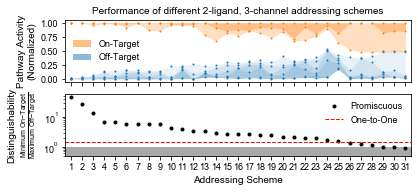

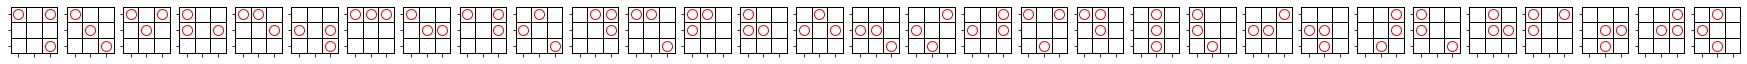

In [11]:
# Generate masks for on- and off-target signals of response matrices
S_inds = np.eye(b, dtype=bool)
S_on = np.where(S_inds == 1)
S_off = np.where(S_inds == 0)
on_dist = np.zeros((len(S_on[0]), n_b))
off_dist = np.zeros((len(S_off[0]), n_b))

# Initialize plots
fig, axes = plt.subplots(2, 1, figsize=(0.2*n_b, 2.5), sharex=True)
plt.sca(axes[0])

# Show results in order of decreasing distinguishability
for i, ind in enumerate(inds_b[inds_b_sort]):
    # Compute responses
    S = psb.sim_S_LAB(model_size, L[np.where(orders[ind])[0]],
                      *psu.unpack_params(params[ind], model_size),
                      norm=True)
    
    # Plot on-target and off-target values
    on, off = S[S_on], S[S_off]
    plt.plot(np.repeat(i, len(on)), on, 'C1.', ms=2)
    plt.plot(np.repeat(i, len(off)), off, 'C0.', ms=2)
    
    # Store sorted values
    on_dist[:, i] = np.sort(on)
    off_dist[:, i] = np.sort(off)

# Plot distribution of on-target and off-target values
for o in range(len(S_on[0]) - 1):
    label = 'On-Target' if o == len(S_on[0]) - 2 else None
    plt.fill_between(np.arange(n_b), on_dist[o], on_dist[o+1],
                     color='C1', lw=0, alpha=0.5*(o+1)/(len(S_on[0])-1),
                     label=label)
for o in range(len(S_off[0]) - 1):
    label = 'Off-Target' if o == len(S_off[0]) - 2 else None
    plt.fill_between(np.arange(n_b), off_dist[-(o+1)], off_dist[-(o+2)],
                     color='C0', lw=0, alpha=0.5*(o+1)/(len(S_off[0])-1),
                     label=label)
plt.legend(fontsize=ticksize, frameon=False)

# Label plot
plt.xticks(np.arange(n_b), np.arange(n_b) + 1)
plt.yticks(np.linspace(0, 1, 5), fontsize=ticksize)
plt.ylabel('Pathway Activity\n(Normalized)', fontsize=labelsize)
plt.title('Performance of different 2-ligand, 3-channel addressing schemes',
          fontsize=labelsize)

# Plot distinguishability values
plt.sca(axes[1])
plt.plot(on_dist[0] / off_dist[-1], 'k.', label='Promiscuous')
print('Distinguishabilities:', on_dist[0] / off_dist[-1], sep='\n')

# Annotate plot
x_min, x_max, y_min = -0.5, n_b - 0.5, 0.5
plt.fill_between([x_min, x_max], y_min, 1, color='darkgray')
dist_theor = np.max(disting_all[c_all == b])
plt.axhline(dist_theor, color='r', ls='--', lw=1, label='One-to-One')
plt.legend(fontsize=ticksize, frameon=False)

# Label plot
plt.xlim(x_min, x_max)
plt.xticks(np.arange(n_b), np.arange(n_b) + 1, fontsize=ticksize)
plt.xlabel('Addressing Scheme', fontsize=labelsize)
plt.yscale('log')
plt.ylim(bottom=y_min)
plt.yticks(fontsize=ticksize)
plt.ylabel('Distinguishability\n' +
       r'$\frac{\mathrm{Minimum\ On{-}Target}}{\mathrm{Maximum\ Off{-}Target}}$',
       fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure2D.pdf'), **savefig_kwargs)

# Show targets in order of decreasing distinguishability
fig, axes = plt.subplots(1, len(inds_b_sort),
                         figsize=(len(inds_b_sort), 1),
                         squeeze=False)
for i, ind in enumerate(inds_b[inds_b_sort]):
    # Plot targets
    psu.plot_targets(np.ones(len(L)).astype(int),
                     L_min=L_min, L_max=L_max, L_res=L_res,
                     axes=axes[0, i],
                     xlabels_on=False, ylabels_on=False,
                     cmap='Greys_r', compact=True)

    # Plot ligand combinations corresponding to orthogonal channels
    inds = np.where(orders[ind])[0]
    L_plot = 10 ** 1.5 * L[inds]
    axes[0, i].plot(L_plot[:, 0], L_plot[:, 1], 'o',
                    mec='r', mew=1, mfc='None', ms=10)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure2D_schemes.pdf'), **savefig_kwargs)

## Figure S2

### Visualize responses for all 3-channel addressing schemes.

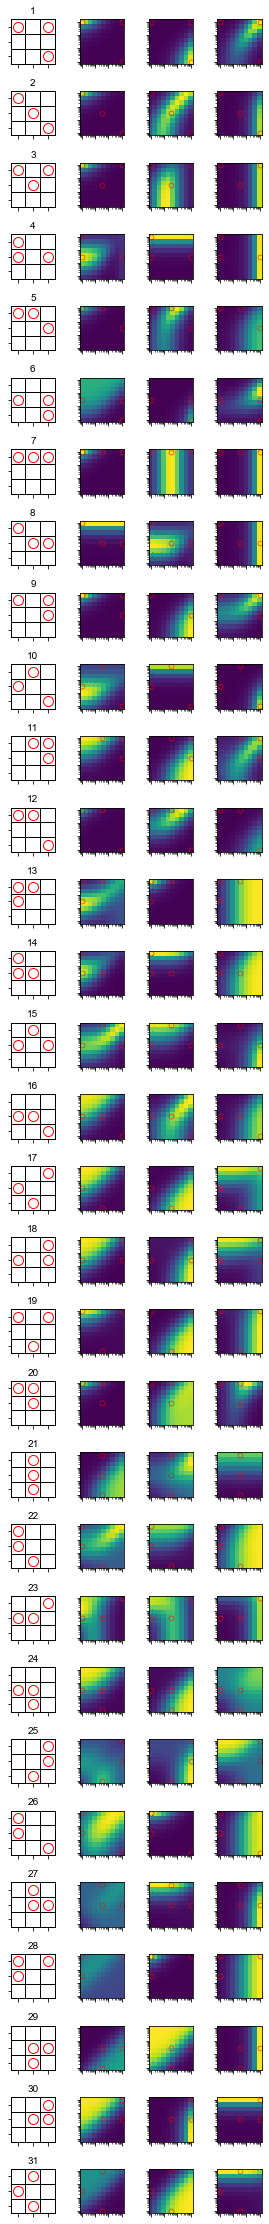

In [12]:
# Initialize plots
fig, axes = plt.subplots(n_b, b + 1, figsize=(b + 1, n_b), squeeze=False)

# Show targets and responses in order of decreasing distinguishability
for i, ind in enumerate(inds_b[inds_b_sort]):
    # Plot targets
    psu.plot_targets(np.ones(len(L)).astype(int),
                     L_min=L_min, L_max=L_max, L_res=L_res,
                     axes=axes[i, 0],
                     xlabels_on=False, ylabels_on=False,
                     cmap='Greys_r', compact=True)

    # Plot ligand combinations corresponding to orthogonal channels
    inds = np.where(orders[ind])[0]
    L_plot = 10 ** 1.5 * L[inds]
    axes[i, 0].plot(L_plot[:, 0], L_plot[:, 1], 'o',
                    mec='r', mew=1, mfc='None', ms=10)
    axes[i, 0].set_title(i + 1, fontsize=labelsize)

    # Plot responses
    R, K, e = psu.unpack_params(params[ind], model_size)
    psu.plot_responses(model_size, L=L_sim, R=R, K=K, e=e,
                       L_min=L_min, L_max=L_max, L_res=L_res_sim,
                       axes=axes[i, 1:],
                       xticks=ticks_r, xlabels_on=False,
                       yticks=ticks_r, ylabels_on=False)
    
    # Plot ligand combinations corresponding to orthogonal channels
    psu.plot_combinations(L_plot, axes=axes[i, 1:],
                          marker_on='o',
                          mec_on='r', mew_on=0.5, mfc_on='None', ms_on=5,
                          marker_off='o',
                          mec_off='r', mew_off=0.5, mfc_off='None', ms_off=5)

    # Label plots
    for j in range(b):
        set_minor_loc(ax=axes[i, j+1])
        axes[i, j+1].xaxis.set_minor_formatter(NullFormatter())
        axes[i, j+1].yaxis.set_minor_formatter(NullFormatter())

plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'FigureS2.pdf'), **savefig_kwargs)

## Figures 3 and S3

Define utility functions to perform receptor perturbations and analyze resulting responses.

In [13]:
def perturb_R(R, cv=0.25, prop_extr=0.5, n_perturb=100):
    '''
    Generate [n_perturb] random receptor perturbations about [R]
    with coefficient of variation [cv] and proportion of
    extrinsic noise [prop_extr].
    '''
    R_perturb = np.zeros((n_perturb, *R.shape))
    
    for p in range(n_perturb):
        R_p = R.copy()
        
        # Sample extrinsic noise (one value for all receptors)
        s_e = np.random.gamma(prop_extr / (cv ** 2), cv ** 2)
        
        # Sample intrinsic noise (one value for each receptor)
        s_i = np.random.gamma((1 - prop_extr) / (cv ** 2), cv ** 2,
                              size=R.shape)
        
        R_p *= (s_e + s_i)
        
        R_perturb[p] = R_p
    
    return R_perturb

def compute_disting_perturb(model_size, L, R_perturb, K, e,
                            return_dist=False):
    '''
    Compute distinguishability for receptor perturbations provided in
    [R_perturb] and biochemical parameters given by [K] and [e].
    Return distributions of on-target and off-target activities
    if [return_dist] is True.
    '''
    disting = []
    on_dist = []
    off_dist = []
    
    # Generate masks for on- and off-target signals of response matrices
    S_inds = np.eye(len(L), dtype=bool)
    S_on = np.where(S_inds == 1)
    S_off = np.where(S_inds == 0)
    
    # Analyze each receptor perturbation
    for p in range(len(R_perturb)):
        # Compute resulting response and distinguishability
        with contextlib.redirect_stdout(open(os.devnull, 'w')):
            S = psb.sim_S_LAB(model_size, L, R_perturb[p], K, e)
        if not len(S):
            print('Error: response matrix not successfully computed.')
        disting.append(1 / psc.crosstalk(S))
        
        if return_dist:
            # Find distributions of on-target and off-target values
            on_dist.append(S[S_on])
            off_dist.append(S[S_off])
    
    if return_dist:
        return disting, on_dist, off_dist
    return disting

def sim_noise(model_size, L, R, K, e, n_perturb=100,
              cvs=[0.5], prop_extrs=[1, 0.5, 0]):
    '''
    Analyze the robustness of the addressing system given by
    [L], [R], [K], and [e] to various types of noise, testing
    all combinations of coefficients of variation in [cvs] and
    proportions of extrinsic noise in [prop_extrs]. Return the
    distinguishabilities as well as distributions of on-target
    and off-target activities from [n_perturb] perturbations
    for each type of noise.
    '''
    noise_params = np.array(list(itertools.product(cvs, prop_extrs)))
    R_noise = np.zeros((len(noise_params), n_perturb, *R.shape))
    disting_noise = np.zeros((len(noise_params), n_perturb))
    on_noise = [[] for noise_param in noise_params]
    off_noise = [[] for noise_param in noise_params]
    
    # Analyze each type of noise
    for i, noise_param in enumerate(noise_params):
        np.random.seed(36)
        
        # Generate random receptor perturbations
        R_noise[i] = perturb_R(R, *noise_param, n_perturb=n_perturb)
        
        disting_noise[i], on_noise[i], off_noise[i] \
            = compute_disting_perturb(model_size, L, R_noise[i], K, e,
                                      return_dist=True)
    
    return disting_noise, on_noise, off_noise

### Process data (Figures 3, S3, and S4) and analyze parameter set yielding highest distinguishability for each bandwidth.

In [14]:
# Initialize variables to store results
b_list = []
params_list = []
on_dist_list = []
on_vals_list = []
off_dist_list = []
off_vals_list = []
d_noise_list = []
auc_list = []
best_list = []

# Analyze specified types of noise in receptor expression
n_perturb = 100
cvs = [0.5]
prop_extrs = [1, 0]
n_noise = len(cvs) * len(prop_extrs)
labels = ['Extrinsic', 'Intrinsic']
colors = ['limegreen', 'orchid']

# Identify examples for further analysis based on distinguishability
d_thresh = 1.5

# Analyze each model
for i, chis in enumerate(all_chis):
    print(all_models[i])
    
    # Extract best result for each addressing scheme
    orders_config = [[] for j in range(len(all_configs[i]))]
    params_config = [[] for j in range(len(all_configs[i]))]
    chis_config = np.inf * np.ones(len(all_configs[i]))
    for config_i in range(len(all_configs[i])):
        if chis[config_i]:
            # Filter out parameter sets of all 0s
            inds = [ind for ind, param in enumerate(all_params[i][config_i])
                    if not np.isclose(np.sum(param), 0)]
            orders_filt = [all_orders[i][config_i][ind] for ind in inds]
            params_filt = [all_params[i][config_i][ind] for ind in inds]
            chis_filt = [all_chis[i][config_i][ind] for ind in inds]
            
            # Find minimum crosstalk (maximum distinguishability)
            opt_i = np.argmin(chis_filt)
            orders_config[config_i] = orders_filt[opt_i]
            params_config[config_i] = params_filt[opt_i]
            chis_config[config_i] = chis_filt[opt_i]
    
    # Analyze addressing schemes by numbers of channels (bandwidths)
    inds_channels = psu.index_configs_by_channels(all_configs[i])
    
    # Initialize variables to store results for each bandwidth
    b_all = np.arange(1, len(inds_channels))
    params = [[] for j in range(len(b_all))]
    on_dist = np.zeros((3, len(b_all)))
    on_vals = [[] for j in range(len(b_all))]
    off_dist = np.zeros((3, len(b_all)))
    off_vals = [[] for j in range(len(b_all))]
    d_noise = [[] for j in range(len(b_all))]
    auc = np.zeros((n_noise, len(b_all)))
    
    # Analyze each bandwidth
    for j, b in enumerate(b_all):
        # Ignore 1-channel case
        if b == 1:
            continue
        
        # Extract configurations with same bandwidth
        inds_b = inds_channels[b]
        n_b = len(inds_b)
        inds_b_sort = np.argsort(chis_config[inds_b])
        print('{:d} channels'.format(b))
        
        # Generate masks for on- and off-target signals of response matrices
        S_inds = np.eye(b, dtype=bool)
        S_on = np.where(S_inds == 1)
        S_off = np.where(S_inds == 0)
        
        # Compute response matrix and distinguishability for best example
        ind_b = inds_b[inds_b_sort[0]]
        R, K, e = psu.unpack_params(params_config[ind_b], all_models[i])
        S = psb.sim_S_LAB(all_models[i], L[np.where(orders_config[ind_b])[0]],
                          R, K, e, norm=True)
        d = 1 / psc.crosstalk(S)
        print('\tDistinguishability:\t{:.4f}'.format(d))
        
        # Store parameter set and check if above desired
        # distinguishability threshold
        params[j] = (orders_config[ind_b], R, K, e)
        if d >= d_thresh:
            best = (orders_config[ind_b], R, K, e)
        
        # Find on-target and off-target values
        on_vals[j] = np.sort(S[S_on])
        off_vals[j] = np.sort(S[S_off])
        
        # Extract summary statistics for on-target and off-target values
        on_dist[:, j] = np.min(on_vals[j]), np.median(on_vals[j]), \
                        np.max(on_vals[j])
        off_dist[:, j] = np.min(off_vals[j]), np.median(off_vals[j]), \
                         np.max(off_vals[j])
        
        # Analyze each type of noise
        d_noise[j], on_noise, off_noise = \
            sim_noise(all_models[i], L[np.where(orders_config[ind_b])[0]],
                      R, K, e, n_perturb=n_perturb,
                      cvs=cvs, prop_extrs=prop_extrs)
        
        # Extract all on-target and off-target values for each type of noise
        on_all = np.array([np.array(on_noise[k]).flatten()
                           for k in range(len(on_noise))])
        off_all = np.array([np.array(off_noise[k]).flatten()
                            for k in range(len(off_noise))])
        
        for k in range(n_noise):
            # Extract true labels and associated scores (normalized activities)
            y_true = np.concatenate((np.ones(len(on_all[k])),
                                     np.zeros(len(off_all[k]))))
            y_score = np.concatenate((on_all[k], off_all[k]))
            
            # Compute ROC and AUC
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            auc[k, j] = roc_auc_score(y_true, y_score)
            print('\tAUC ({:s} Noise):\t{:.4f}'.format(labels[k], auc[k, j]))
    print('')
    
    b_list.append(b_all)
    params_list.append(params)
    off_dist_list.append(off_dist)
    off_vals_list.append(off_vals)
    on_dist_list.append(on_dist)
    on_vals_list.append(on_vals)
    d_noise_list.append(d_noise)
    auc_list.append(auc)
    best_list.append(best)

(2, 2, 2)
2 channels
	Distinguishability:	9596.4512
	AUC (Extrinsic Noise):	1.0000
	AUC (Intrinsic Noise):	1.0000
3 channels
	Distinguishability:	47.6438
	AUC (Extrinsic Noise):	0.9992
	AUC (Intrinsic Noise):	0.9914
4 channels
	Distinguishability:	4.6276
	AUC (Extrinsic Noise):	0.9793
	AUC (Intrinsic Noise):	0.9428
5 channels
	Distinguishability:	3.6189
	AUC (Extrinsic Noise):	0.9820
	AUC (Intrinsic Noise):	0.9400
6 channels
	Distinguishability:	1.2113
	AUC (Extrinsic Noise):	0.9398
	AUC (Intrinsic Noise):	0.8924
7 channels
	Distinguishability:	1.0877
	AUC (Extrinsic Noise):	0.9405
	AUC (Intrinsic Noise):	0.8882
8 channels
	Distinguishability:	0.7359
	AUC (Extrinsic Noise):	0.9104
	AUC (Intrinsic Noise):	0.8696

(2, 4, 3)
2 channels
	Distinguishability:	2287.9688
	AUC (Extrinsic Noise):	1.0000
	AUC (Intrinsic Noise):	1.0000
3 channels
	Distinguishability:	48.6663
	AUC (Extrinsic Noise):	1.0000
	AUC (Intrinsic Noise):	0.9912
4 channels
	Distinguishability:	19.1088
	AUC (Extrinsic Noise)

### Analyze performance of best parameter set for each bandwidth.

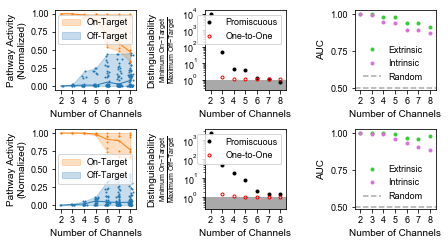

In [15]:
np.random.seed(36)

# Identify highest distinguishability achieved in one-to-one architecture
disting_max = np.array([np.max(disting_c) for disting_c in disting_all])

# Initialize plots
fig, axes = plt.subplots(len(b_list), 3, figsize=(6.25, 1.75 * len(b_list)))
major_loc = plt.LogLocator(numticks=10)
d_label = 'Distinguishability\n' + \
    r'$\frac{\mathrm{Minimum\ On{-}Target}}{\mathrm{Maximum\ Off{-}Target}}$'

# Analyze each model
for i, b_all in enumerate(b_list):
    ######################################################################
    # Pathway Activity
    ######################################################################
    
    # Plot on-target and off-target values
    plt.sca(axes[i, 0])
    for j, b in enumerate(b_all):
        plt.plot(np.repeat(b, len(on_vals_list[i][j])),
                 on_vals_list[i][j], 'C1.', ms=2)
        plt.plot(np.random.normal(b, 0.1, len(off_vals_list[i][j])),
                 off_vals_list[i][j], 'C0.', ms=2)
    
    # Plot distribution of on-target and off-target values
    plt.fill_between(b_all[1:], on_dist_list[i][0][1:],
                     on_dist_list[i][-1][1:],
                     color='C1', alpha=0.25, label='On-Target')
    plt.plot(b_all[1:], on_dist_list[i][1][1:], 'C1-', lw=1)
    plt.fill_between(b_all[1:], off_dist_list[i][0][1:],
                     off_dist_list[i][-1][1:],
                     color='C0', alpha=0.25, label='Off-Target')
    plt.plot(b_all[1:], off_dist_list[i][1][1:], 'C0-', lw=1)
    plt.legend(fontsize=ticksize)
    
    # Label plot
    x_min, x_max = b_all[1] - 0.5, b_all[-1] + 0.5
    plt.xlim(x_min, x_max)
    plt.xticks(b_all[1:], fontsize=ticksize)
    plt.xlabel('Number of Channels', fontsize=labelsize)
    plt.yticks(np.linspace(0, 1, 5), fontsize=ticksize)
    plt.ylabel('Pathway Activity\n(Normalized)', fontsize=labelsize)
    
    ######################################################################
    # Distinguishability
    ######################################################################
    
    # Plot distinguishability values for promiscuous architecture
    plt.sca(axes[i, 1])
    plt.plot(b_all[1:], on_dist_list[i][0][1:] / off_dist_list[i][-1][1:],
             'k.', label='Promiscuous')
    
    # Plot distinguishability values for one-to-one architecture
    inds_c = (n < c_all) & (c_all <= b_all[-1])
    plt.plot(c_all[inds_c], disting_max[inds_c],
             'r.', fillstyle='none', label='One-to-One')
    
    # Annotate plot
    plt.legend(fontsize=ticksize)
    x_min, x_max, y_min = b_all[1] - 0.5, b_all[-1] + 0.5, 0.25
    plt.fill_between([x_min, x_max], y_min, 1, color='darkgray')
    
    # Label plot
    plt.xlim(x_min, x_max)
    plt.xticks(b_all[1:], fontsize=ticksize)
    plt.xlabel('Number of Channels', fontsize=labelsize)
    plt.yscale('log')
    plt.ylim(bottom=y_min)
    axes[i, 1].yaxis.set_major_locator(major_loc)
    set_minor_loc(axis='y', ax=axes[i, 1])
    axes[i, 1].tick_params(axis='y', which='both', labelsize=ticksize)
    plt.ylabel(d_label, fontsize=labelsize)
    
    ######################################################################
    # AUC
    ######################################################################
    
    # Plot AUC values for extrinsic and intrinsic noise
    plt.sca(axes[i, 2])
    for j in range(n_noise):
        plt.plot(b_all[1:], auc_list[i][j][1:],
                 '.', color=colors[j], label=labels[j])
    
    # Annotate plot
    x_min, x_max, y_min = b_all[1] - 0.5, b_all[-1] + 0.5, 0.49
    plt.axhline(0.5, color='darkgray', ls='--', label='Random')
    plt.legend(fontsize=ticksize, frameon=False)
    
    # Label plot
    plt.xlim(x_min, x_max)
    plt.xticks(b_all[1:], fontsize=ticksize)
    plt.xlabel('Number of Channels', fontsize=labelsize)
    plt.ylim(bottom=y_min)
    plt.yticks([0.5, 0.75, 1], fontsize=ticksize)
    plt.ylabel('AUC', fontsize=labelsize)

plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure3ABCEFG.pdf'), **savefig_kwargs)

### Visualize receiver operating characteristic (ROC) curve for example high-bandwidth system.

(2, 2, 2)
5 channels
AUC (Intrinsic Noise):	0.9400


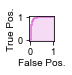

In [16]:
# Specify system to show
i = 0
j = 4
k = 1
print(all_models[i])
print('{:d} channels'.format(b_list[i][j]))

# Analyze each type of noise
order, R, K, e = params_list[i][j]
_, on_noise, off_noise = sim_noise(all_models[i], L[np.where(order)[0]],
                                   R, K, e, n_perturb=n_perturb,
                                   cvs=cvs, prop_extrs=prop_extrs)

# Extract all on-target and off-target values for each type of noise
on_all = np.array([np.array(on_noise[k]).flatten()
                   for k in range(len(on_noise))])
off_all = np.array([np.array(off_noise[k]).flatten()
                    for k in range(len(off_noise))])

# Extract true labels and associated scores (normalized activities)
y_true = np.concatenate((np.ones(len(on_all[k])),
                         np.zeros(len(off_all[k]))))
y_score = np.concatenate((on_all[k], off_all[k]))

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_val = roc_auc_score(y_true, y_score)
print('AUC ({:s} Noise):\t{:.4f}'.format(labels[k], auc_val))

# Plot ROC curve
plt.figure(figsize=(0.45, 0.45))
plt.plot(fpr, tpr, color=colors[k])
plt.fill_between(fpr, tpr, color=colors[k], alpha=0.25)

# Label plot
plt.locator_params(axis='both', nbins=2)
plt.axis('square')
plt.gca().tick_params(axis='both', labelsize=ticksize)
plt.xlabel('False Pos.', fontsize=labelsize, labelpad=2)
plt.ylabel('True Pos.', fontsize=labelsize, labelpad=1)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure3C_ROC.pdf'), **savefig_kwargs)

### Visualize responses and crosstalk matrices for example high-bandwidth systems.

Receptor Expression:
[[ True  True  True False  True  True False]
 [False False  True False  True False False]
 [ True False False  True  True  True False]
 [ True  True False  True False  True  True]
 [False False  True  True False  True False]
 [ True False  True  True False False  True]
 [False False False  True False False  True]
 [False  True False  True False  True False]]


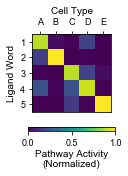

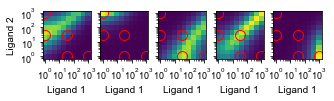

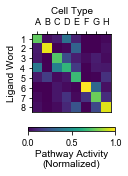

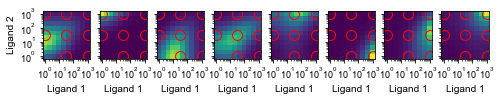

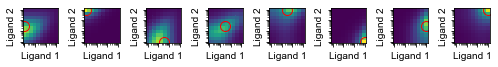

In [17]:
fignum = 1
panels_m = ['3D', '3H']
panels_r = ['S3A', '3I']

# Analyze each model
for i, best in enumerate(best_list):
    order, R, K, e = best
    
    # Plot crosstalk matrix
    S = psb.sim_S_LAB(all_models[i], L[np.where(order)[0]],
                      R, K, e, norm=True).T
    if save_fig:
        out_file = os.path.join(out_dir, 'Figure{}.pdf'.format(panels_m[i]))
    else:
        out_file = None
    plot_matrix(S, fignum=fignum, out_file=out_file)
    fignum += 1
    
    # Plot responses
    if save_fig:
        out_file = os.path.join(out_dir, 'Figure{}.pdf'.format(panels_r[i]))
    else:
        out_file = None
    plot_responses(all_models[i], R, K, e, L, L_sim, order,
                   out_file=out_file)
    fignum += 1

# Show receptor profiles for example high-bandwidth system
i = 1
order, R, K, e = best_list[i]
print('Receptor Expression:', R > 0.1 * np.max(R), sep='\n')

# Plot responses
fig, axes = plt.subplots(1, len(R), figsize=(7, 1.25))
ticks = 10 ** np.arange(L_min, L_max + 1)
psu.plot_responses(all_models[i], R=R, K=K, e=e, L=L_sim,
                   L_min=L_min, L_max=L_max, L_res=L_res_sim, axes=axes,
                   xticks=ticks, xlabels_on=False,
                   yticks=ticks, ylabels_on=False)

# Plot ligand combinations corresponding to orthogonal channels
L_plot = 10 ** 1.5 * L[np.where(order)[0]]
psu.plot_combinations(L_plot, axes=axes,
                      marker_on='o', mec_on='r', mew_on=1,
                      mfc_on='None', ms_on=10,
                      marker_off='o', mec_off='r', mew_off=0,
                      mfc_off='None', ms_off=10)

# Label plot
for i in range(len(R)):
    set_minor_loc(ax=axes[i])
    axes[i].xaxis.set_minor_formatter(NullFormatter())
    axes[i].yaxis.set_minor_formatter(NullFormatter())
    axes[i].set_xlabel('Ligand 1', fontsize=labelsize, labelpad=2)
    axes[i].set_ylabel('Ligand 2', fontsize=labelsize, labelpad=1)

plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'GraphicalAbstract.pdf'),
                **savefig_kwargs)

### Analyze robustness to noise in receptor expression.

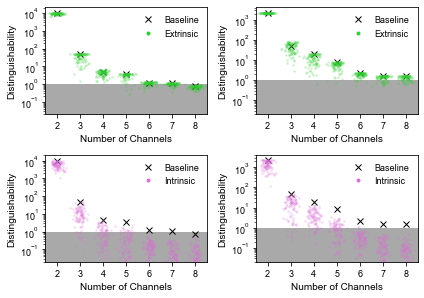

In [18]:
np.random.seed(36)

# Initialize plots
fig, axes = plt.subplots(n_noise, len(b_list), figsize=(6, 4.25), sharey='col')
major_loc = plt.LogLocator(numticks=10)

# Analyze each model
for i, b_all in enumerate(b_list):
    # Analyze each type of noise
    for j in range(n_noise):
        plt.sca(axes[j, i])
        
        # Plot distinguishability values for baseline
        plt.plot(b_all[1:],
                 on_dist_list[i][0][1:] / off_dist_list[i][-1][1:], 'kx')
        
        # Analyze each bandwidth
        for k, b in enumerate(b_all):
            # Ignore 1-channel case
            if b == 1:
                continue
            
            # Plot distinguishability values with noise
            plt.plot(np.random.normal(b, 0.15, n_perturb),
                     d_noise_list[i][k][j], '.',
                     mec='None', mfc=colors[j], alpha=0.25, ms=5)
        
        # Annotate plot
        plt.plot(np.nan, np.nan, 'kx', label='Baseline')
        plt.plot(np.nan, np.nan, '.', color=colors[j], label=labels[j])
        plt.legend(fontsize=ticksize, frameon=False)
        x_min, x_max, y_min = b_all[1] - 0.5, b_all[-1] + 0.5, 0.02
        plt.fill_between([x_min, x_max], y_min, 1, color='darkgray')
        
        # Label plot
        plt.xlim(x_min, x_max)
        plt.xticks(b_all[1:], fontsize=ticksize)
        plt.xlabel('Number of Channels', fontsize=labelsize)
        plt.yscale('log')
        plt.ylim(bottom=y_min)
        axes[j, i].yaxis.set_major_locator(major_loc)
        set_minor_loc(axis='y', ax=axes[j, i])
        axes[j, i].tick_params(axis='y', which='both', labelsize=ticksize)
        plt.ylabel('Distinguishability', fontsize=labelsize)

plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'FigureS3B.pdf'), **savefig_kwargs)

## Figure S4

### Analyze performance of best system for varying distinguishability thresholds.

(2, 2, 2)
Distinguishability threshold 2: 5 channels
	AUC (Extrinsic Noise):	0.9820
	AUC (Intrinsic Noise):	0.9400

(2, 2, 2)
Distinguishability threshold 4: 4 channels
	AUC (Extrinsic Noise):	0.9793
	AUC (Intrinsic Noise):	0.9428

(2, 2, 2)
Distinguishability threshold 10: 3 channels
	AUC (Extrinsic Noise):	0.9992
	AUC (Intrinsic Noise):	0.9914

(2, 4, 3)
Distinguishability threshold 2: 6 channels
	AUC (Extrinsic Noise):	0.9683
	AUC (Intrinsic Noise):	0.9309

(2, 4, 3)
Distinguishability threshold 4: 5 channels
	AUC (Extrinsic Noise):	0.9924
	AUC (Intrinsic Noise):	0.9608

(2, 4, 3)
Distinguishability threshold 10: 4 channels
	AUC (Extrinsic Noise):	0.9983
	AUC (Intrinsic Noise):	0.9944



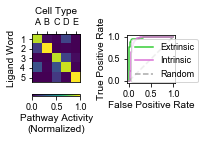

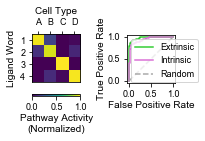

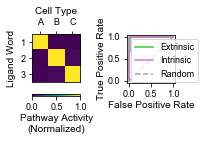

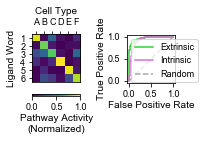

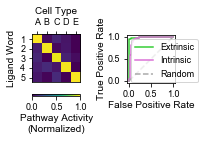

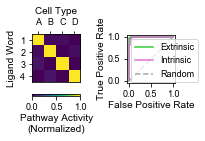

In [19]:
panels = ['S4A', 'S4B', 'S4C', 'S4D', 'S4E', 'S4F']
panel_ind = 0

# Analyze specified distinguishability thresholds
thresh_all = [2, 4, 10]

# Analyze specified types of noise in receptor expression
n_perturb = 100
cvs = [0.5]
prop_extrs = [1, 0]
n_noise = len(cvs) * len(prop_extrs)
labels = ['Extrinsic', 'Intrinsic']
colors = ['limegreen', 'orchid']

# Analyze each model
for i, b_all in enumerate(b_list):
    # Compute distinguishability values
    d_all = on_dist_list[i][0][1:] / off_dist_list[i][-1][1:]
    
    # Analyze each distinguishability threshold
    for thresh in thresh_all:
        # Initialize plots
        fig, axes = plt.subplots(1, 2, figsize=(2.75, 2))
        
        # Identify maximum bandwidth achieved at desired distinguishability
        ind = np.max(np.where(d_all > thresh)[0]) + 1
        order, R, K, e = params_list[i][ind]
        print(all_models[i])
        print('Distinguishability threshold {:d}: {:d} channels'.format(
              thresh, b_all[ind]))
        
        # Plot crosstalk matrix
        plt.sca(axes[0])
        S = psb.sim_S_LAB(all_models[i], L[np.where(order)[0]],
                          R, K, e, norm=True).T
        plot_matrix(S, fignum=0, out_file=None)
        
        # Analyze each type of noise
        _, on_noise, off_noise = \
            sim_noise(all_models[i], L[np.where(order)[0]],
                      R, K, e, n_perturb=n_perturb,
                      cvs=cvs, prop_extrs=prop_extrs)
        
        # Extract all on-target and off-target values for each type of noise
        on_all = np.array([np.array(on_noise[k]).flatten()
                           for k in range(len(on_noise))])
        off_all = np.array([np.array(off_noise[k]).flatten()
                            for k in range(len(off_noise))])
        
        # Plot ROC curves
        plt.sca(axes[1])
        for k in range(n_noise):
            # Extract true labels and associated scores (normalized activities)
            y_true = np.concatenate((np.ones(len(on_all[k])),
                                     np.zeros(len(off_all[k]))))
            y_score = np.concatenate((on_all[k], off_all[k]))
            
            # Compute ROC and AUC
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            auc_val = roc_auc_score(y_true, y_score)
            print('\tAUC ({:s} Noise):\t{:.4f}'.format(labels[k], auc_val))
            
            # Plot ROC curve
            plt.plot(fpr, tpr, color=colors[k], label=labels[k])
        
        # Annotate plot
        plt.plot([0, 1], [0, 1], color='darkgray', ls='--', label='Random')
        plt.legend(fontsize=ticksize)
        
        # Label plot
        plt.locator_params(axis='both', nbins=3)
        plt.axis('square')
        axes[1].tick_params(axis='both', labelsize=ticksize)
        plt.xlabel('False Positive Rate', fontsize=labelsize, labelpad=2)
        plt.ylabel('True Positive Rate', fontsize=labelsize, labelpad=1)
        
        plt.tight_layout()
        
        if save_fig:
            out_file = 'Figure{}.pdf'.format(panels[panel_ind])
            plt.savefig(os.path.join(out_dir, out_file), **savefig_kwargs)
        panel_ind += 1
        print('')

## Figure S5

### Read in results for orthogonal addressing in promiscuous architecture, with higher-resolution ligand discretization.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [20]:
data_dir = os.path.join('..', 'Data')
data_file = 'FigureS5_4-level-optimization.pkl'

# Specify key parameters for ligand titration
L_min, L_max, L_res = 0, 3, 4
L_sim = psb.titrate_ligand(nL=2, L_min=-1.5, L_max=1.5, n_conc=10)

# Read in results for orthogonal addressing in promiscuous system
with open(os.path.join(data_dir, data_file), 'rb') as f:
    L, all_models, all_params, all_errs, all_configs, all_chis = \
        pickle.load(f)

### Process data and analyze parameter set yielding highest distinguishability for each bandwidth.

In [21]:
# Initialize variables to store results
b_list = []
b_last_list = []
params_list = []
on_dist_list = []
on_vals_list = []
off_dist_list = []
off_vals_list = []
best_list = []

# Identify examples for further analysis based on distinguishability
d_thresh = 1

# Analyze each model
for i, chis in enumerate(all_chis):
    print(all_models[i])
    
    # Initialize variables to store results for each bandwidth
    b_all = np.arange(1, len(chis))
    params = [[] for j in range(len(b_all))]
    on_dist = np.zeros((3, len(b_all)))
    on_vals = [[] for j in range(len(b_all))]
    off_dist = np.zeros((3, len(b_all)))
    off_vals = [[] for j in range(len(b_all))]
    
    # Analyze each bandwidth
    for j, b in enumerate(b_all):
        # Ignore 1-channel case
        if b == 1:
            continue
        
        # Ignore bandwidths for which optimizations have not been performed
        if not chis[b]:
            continue
        
        b_last = b
        print('{:d} channels'.format(b))
        
        # Find minimum crosstalk (maximum distinguishability)
        opt_i = np.argmin(chis[b])
        order = all_configs[i][b][opt_i]
        R, K, e = psu.unpack_params(all_params[i][b][opt_i], all_models[i])
        params[j] = (order, R, K, e)
        
        # Generate masks for on- and off-target signals of response matrices
        S_inds = np.eye(b, dtype=bool)
        S_on = np.where(S_inds == 1)
        S_off = np.where(S_inds == 0)
        
        # Compute response matrix and distinguishability for best example
        S = psb.sim_S_LAB(all_models[i], L[np.where(order)[0]],
                          R, K, e, norm=True)
        d = 1 / psc.crosstalk(S)
        print('\tDistinguishability:\t{:.4f}'.format(d))
        
        # Store parameter set and check if above desired
        # distinguishability threshold
        if d >= d_thresh:
            best = (order, R, K, e)
        
        # Find on-target and off-target values
        on_vals[j] = np.sort(S[S_on])
        off_vals[j] = np.sort(S[S_off])
        
        # Extract summary statistics for on-target and off-target values
        on_dist[:, j] = np.min(on_vals[j]), np.median(on_vals[j]), \
                        np.max(on_vals[j])
        off_dist[:, j] = np.min(off_vals[j]), np.median(off_vals[j]), \
                         np.max(off_vals[j])
    print('')
    
    b_list.append(b_all)
    b_last_list.append(b_last)
    params_list.append(params)
    off_dist_list.append(off_dist)
    off_vals_list.append(off_vals)
    on_dist_list.append(on_dist)
    on_vals_list.append(on_vals)
    best_list.append(best)

(2, 2, 2)
2 channels
	Distinguishability:	335.2218
3 channels
	Distinguishability:	3.1876
4 channels
	Distinguishability:	2.5664
5 channels
	Distinguishability:	2.3455
6 channels
	Distinguishability:	0.9946

(2, 4, 3)
2 channels
	Distinguishability:	151.1595
3 channels
	Distinguishability:	9.9846
4 channels
	Distinguishability:	2.9939
5 channels
	Distinguishability:	2.6923
6 channels
	Distinguishability:	2.0617
7 channels
	Distinguishability:	2.2215
8 channels
	Distinguishability:	1.4268



### Analyze performance of best parameter set for each bandwidth.

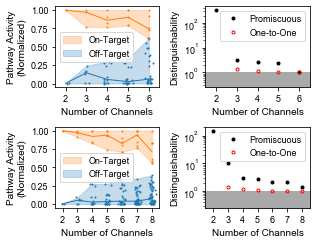

In [22]:
np.random.seed(36)

# Identify highest distinguishability achieved in one-to-one architecture
disting_max = np.array([np.max(disting_c) for disting_c in disting_all])

# Initialize plots
fig, axes = plt.subplots(len(b_list), 2, figsize=(4.5, 1.75 * len(b_list)))

# Analyze each model
for i, b_all in enumerate(b_list):
    b_last = b_last_list[i]
    
    ######################################################################
    # Pathway Activity
    ######################################################################
    
    # Plot on-target and off-target values
    plt.sca(axes[i, 0])
    for j, b in enumerate(b_all):
        plt.plot(np.repeat(b, len(on_vals_list[i][j])),
                 on_vals_list[i][j], 'C1.', ms=2)
        plt.plot(np.random.normal(b, 0.1, len(off_vals_list[i][j])),
                 off_vals_list[i][j], 'C0.', ms=2)
    
    # Plot distribution of on-target and off-target values
    plt.fill_between(b_all[1:b_last], on_dist_list[i][0][1:b_last],
                     on_dist_list[i][-1][1:b_last],
                     color='C1', alpha=0.25, label='On-Target')
    plt.plot(b_all[1:b_last], on_dist_list[i][1][1:b_last], 'C1-', lw=1)
    plt.fill_between(b_all[1:b_last], off_dist_list[i][0][1:b_last],
                     off_dist_list[i][-1][1:b_last],
                     color='C0', alpha=0.25, label='Off-Target')
    plt.plot(b_all[1:b_last], off_dist_list[i][1][1:b_last], 'C0-', lw=1)
    plt.legend(fontsize=ticksize)
    
    # Label plot
    x_min, x_max = b_all[1] - 0.5, b_last + 0.5
    plt.xlim(x_min, x_max)
    plt.xticks(b_all[1:b_last], fontsize=ticksize)
    plt.xlabel('Number of Channels', fontsize=labelsize)
    plt.yticks(np.linspace(0, 1, 5), fontsize=ticksize)
    plt.ylabel('Pathway Activity\n(Normalized)', fontsize=labelsize)
    
    ######################################################################
    # Distinguishability
    ######################################################################
    
    # Plot distinguishability values for promiscuous architecture
    plt.sca(axes[i, 1])
    plt.plot(b_all[1:b_last],
             on_dist_list[i][0][1:b_last] / off_dist_list[i][-1][1:b_last],
             'k.', label='Promiscuous')
    
    # Plot distinguishability values for one-to-one architecture
    inds_c = (n < c_all) & (c_all <= b_last)
    plt.plot(c_all[inds_c], disting_max[inds_c],
             'r.', fillstyle='none', label='One-to-One')
    
    # Annotate plot
    plt.legend(fontsize=ticksize)
    x_min, x_max, y_min = b_all[1] - 0.5, b_last + 0.5, 0.25
    plt.fill_between([x_min, x_max], y_min, 1, color='darkgray')
    
    # Label plot
    plt.xlim(x_min, x_max)
    plt.xticks(b_all[1:b_last], fontsize=ticksize)
    plt.xlabel('Number of Channels', fontsize=labelsize)
    plt.yscale('log')
    plt.ylim(bottom=y_min)
    set_minor_loc(axis='y', ax=axes[i, 1])
    axes[i, 1].tick_params(axis='y', which='both', labelsize=ticksize)
    plt.ylabel('Distinguishability', fontsize=labelsize)

plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'FigureS5ABEF.pdf'), **savefig_kwargs)

### Visualize responses and crosstalk matrices for example high-bandwidth systems.

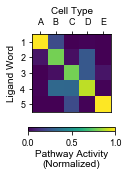

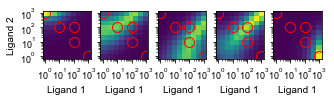

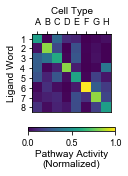

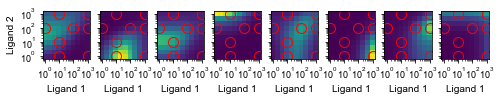

In [23]:
fignum = 1
panels_m = ['S5C', 'S5G']
panels_r = ['S5D', 'S5H']

# Analyze each model
for i, best in enumerate(best_list):
    order, R, K, e = best
    
    # Plot crosstalk matrix
    S = psb.sim_S_LAB(all_models[i], L[np.where(order)[0]],
                      R, K, e, norm=True).T
    if save_fig:
        out_file = os.path.join(out_dir, 'Figure{}.pdf'.format(panels_m[i]))
    else:
        out_file = None
    plot_matrix(S, fignum=fignum, out_file=out_file)
    fignum += 1
    
    # Plot responses
    if save_fig:
        out_file = os.path.join(out_dir, 'Figure{}.pdf'.format(panels_r[i]))
    else:
        out_file = None
    plot_responses(all_models[i], R, K, e, L, L_sim, order,
                   out_file=out_file)
    fignum += 1

# Analysis of subset addressing

## Figure 4

Define utility functions to analyze and visualize addressing repertoires.

In [24]:
def make_binary_vector(repertoire):
    '''
    Determine the binary vector representation of an
    addressing repertoire from the string designation.
    
    Input:
    - repertoire: an addressing repertoire of 3 cell types
                  (from the list of 40 possibilities)
    
    Output:
    - A length-7 tuple of 0s and 1s, where a 1 indicates the
      presence of a subset in an addressing repertoire.
      Each value corresponds to a specific subset, ordered as
      ('A', 'B', 'C', 'BC', 'AC', 'AB', 'ABC').
    '''
    bin_vector = np.zeros((7, ))
    for i in range(3):
        bin_vector[(3 * i):(3 * i) + int(repertoire[i])] = 1
    if len(repertoire) == 4 and repertoire[3] == 'n':
        bin_vector[3], bin_vector[5] = 0, 1
    return tuple(bin_vector)

def plot_glyph(repertoire, axis=None, sp_size=2, print_labels=False):
    '''
    Plot a Venn diagram representing an addressing repertoire.
    
    Inputs:
    - repertoire: the repertoire to plot, represented as a binary vector
                  of length 7 (as generated by make_binary_vector)
    - axis: optional specification of axis on which to plot
    - sp_size: optional specification of subplot size
    - print_labels: optional specification of whether to label each
                    subset on Venn diagram
    '''
    if axis is None:
        fig, axis = plt.subplots(figsize=(sp_size, sp_size))
    
    labels = ['A', 'B', 'C', 'BC', 'AC', 'AB', 'ABC']
    colors = [(1, 0, 1), (1, 1, 0), (0, 1, 1),
              (0.5, 1, 0.5), (0.5, 0.5, 1), (1, 0.5, 0.5), (1, 1, 1)]
    v = venn3(subsets=(1, 1, 1, 1, 1, 1, 0.5), set_labels=None, ax=axis)
    for i, label in enumerate(labels):
        ID = ''.join([str(int(char in label)) for char in ('A', 'B', 'C')])
        if print_labels:
            v.get_label_by_id(ID).set_text(label)
        else:
            v.get_label_by_id(ID).set_text('')
        p = v.get_patch_by_id(ID)
        p.set_alpha(1.0)
        p.set_edgecolor('black')
        p.set_linewidth(0.4)
        if repertoire[i] == 0:
            p.set_facecolor('0.6')
        else:
            p.set_facecolor(colors[i])
    
    axis.set_aspect('equal')
    axis.axison = False
    
    return axis

### Read in results for subset addressing in promiscuous architecture.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [25]:
data_dir = os.path.join('..', 'Data')
data_file = 'Figure4_subset-addressing.pkl'

# Specify key parameters for ligand titration
model_size = (2, 4, 3)
L_rep = psb.titrate_ligand(nL=2, L_min=-2, L_max=2, n_conc=3)

# Read in results for orthogonal addressing in promiscuous system
with open(os.path.join(data_dir, data_file), 'rb') as f:
    all_rep, all_target, all_K, all_e, all_R, all_chi = pickle.load(f)
    all_d = 1 / all_chi

# Sort repertoires in order of decreasing distinguishability
inds_sort = np.argsort(-all_d)
all_rep = list(np.array(all_rep)[inds_sort])
all_target = all_target[inds_sort]
all_K = all_K[inds_sort]
all_e = all_e[inds_sort]
all_R = all_R[inds_sort]
all_d = all_d[inds_sort]

### Visualize responses for example addressing repertoire (fully addressable system).

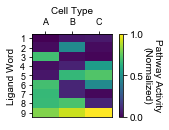

In [26]:
# Specify desired addressing repertoire
rep = '331'
ind = all_rep.index(rep)
R, K, e = all_R[ind], all_K[ind], all_e[ind]

# Plot response matrix
plt.figure(figsize=(2.5, 1.5))
S = psb.sim_S_LAB(model_size, L_rep, R, K, e, norm=True).T
plt.matshow(S[:, [1, 0, 2]], fignum=1, aspect=0.35, vmin=0, vmax=1)
plt.xticks(np.arange(len(S.T)),
           [chr(ord('A') + i) for i in np.arange(len(S.T))],
           fontsize=ticksize)
plt.tick_params('x', bottom=False)
plt.xlabel('Cell Type', fontsize=labelsize)
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(len(S)), np.arange(len(S)) + 1, fontsize=ticksize)
plt.ylabel('Ligand Word', fontsize=labelsize)

# Generate colorbar
ticks = np.arange(0, 1.01, 0.5)
cb = plt.colorbar(fraction=0.045, ticks=ticks)
cb.ax.set_xticklabels(ticks, fontsize=ticksize, rotation=0)
cb.set_label('Pathway Activity\n(Normalized)',
             fontsize=labelsize, rotation=-90, labelpad=18)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure4B.pdf'), **savefig_kwargs)

### Analyze performance of all addressing repertoires of 3 cell types.

Distinguishabilities:
[88.17718919 79.08125059 36.52394363 33.95159729 29.39628223 22.92191296
 22.10059087 21.51998575 19.49841975 19.03850271 16.15532951 16.11958421
 14.87724339 14.04038737 13.92087211 13.53033724 12.90716146 12.16516812
 11.89617818 10.66331357 10.30455974  9.85469413  9.44490039  4.53300566
  3.88091697  3.43624307  3.35706963  3.03676519  2.17000879  1.89762107
  1.83186193  1.02977289]


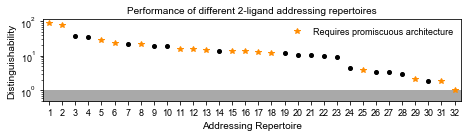

In [27]:
# Differentiate repertoires that are or are not possible
# in a one-to-one pathway architecture
inds_not_poss, inds_poss = [], []
for i, rep in enumerate(all_rep):
    bin_vector = make_binary_vector(rep)
    if bin_vector[-1] == 0:
        inds_not_poss.append(i)
    else:
        inds_poss.append(i)

# Plot distinguishability values
colors = ['k', 'darkorange']
plt.figure(figsize=(7.5, 1.5))
plt.plot(inds_poss, all_d[inds_poss],
         '.', color=colors[0], ms=8)
plt.plot(inds_not_poss, all_d[inds_not_poss],
         '*', color=colors[1], label='Requires promiscuous architecture')
print('Distinguishabilities:', all_d, sep='\n')

# Annotate plot
x_min, x_max, y_min = -0.5, len(all_rep) - 0.5, 0.5
plt.fill_between([x_min, x_max], y_min, 1, color='darkgray')
plt.legend(loc='upper right', fontsize=ticksize, frameon=False)

# Label plot
plt.xlim(x_min, x_max)
plt.xticks(np.arange(len(all_rep)), np.arange(len(all_rep)) + 1,
           fontsize=ticksize)
plt.xlabel('Addressing Repertoire', fontsize=labelsize)
plt.yscale('log')
plt.ylim(bottom=y_min)
plt.yticks(fontsize=ticksize)
plt.ylabel('Distinguishability', fontsize=labelsize)
plt.title('Performance of different 2-ligand addressing repertoires',
          fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure4C.pdf'), **savefig_kwargs)

fig, axes = plt.subplots(1, len(all_rep), figsize=(7.75, 0.5))
for i, axis in enumerate(axes):
    bin_vector = make_binary_vector(all_rep[i])
    plot_glyph(bin_vector, axis=axis)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure4C_repertoires.pdf'),
                **savefig_kwargs)

# Analysis of _in vitro_ addressing

## Figure 5

Define utility functions to analyze and visualize experimental data.

In [28]:
def process_data_exp(df, ligs, cell_types):
    # Aggregate data across biological replicates by taking mean activity
    df_agg = pd.pivot_table(df, values='Relative Activity',
                            index=['Cell Type'] + ligs,
                            aggfunc=(np.mean, np.std)).reset_index()
    df_agg = df_agg.sort_values(by=ligs)
    df_agg = df_agg.rename({'mean': 'Relative Activity',
                            'std': 'Standard Deviation'}, axis=1)
    
    # Normalize activities between 0 and 1, clipping relative activity at 1
    max_act = pd.pivot_table(df_agg, values='Relative Activity',
                             index='Cell Type', aggfunc=(np.max))
    max_act = max_act.rename({'Relative Activity': 'Max Activity'}, axis=1)
    df_norm = df.join(max_act, on='Cell Type')
    df_norm['Clipped Activity'] = df_norm['Relative Activity'].clip(1)
    df_norm['Normalized Activity'] = \
        (df_norm['Clipped Activity']) / (df_norm['Max Activity'])
    
    # Extract and normalize responses for each cell line
    S_norm = []
    for i, cell_type in enumerate(cell_types):
        # Extract data for corresponding cell line
        data = pd.pivot_table(df_norm.loc[df_norm['Cell Type'] == cell_type],
                              values='Normalized Activity',
                              index=ligs[0], columns=ligs[1])
        titration = data.index
        S_norm.append(data.to_numpy().flatten())
    S_norm = np.array(S_norm).T
    
    return df_norm, S_norm, titration

def get_tick_labels(ticks):
    labels = []
    for tick in ticks:
        if tick == 0:
            labels.append(r'$0$')
        elif np.log10(tick) % 1 == 0:
            labels.append(r'$10^{{{:g}}}$'.format(np.log10(tick)))
        else:
            labels.append(r'')
    return labels

def plot_responses_exp(model_size, S, titration, L_channels,
                       ligs, cell_types, vmin=0,
                       fig=None, axes=None, out_file=None):
    # Specify ticks for plotting
    L_min, L_max, L_res = -5/3, 3, 8
    ticks = np.logspace(L_min, L_max, L_res)
    
    # Specify tick labels from known ligand titration
    ticklabels = get_tick_labels(titration)
    
    # Plot responses
    if fig is None or axes is None:
        fig, axes = plt.subplots(1, len(cell_types),
                                 figsize=(1.75 * len(cell_types), 2))
    psu.plot_responses(model_size=model_size, matrices=S.T,
                       L_min=L_min, L_max=L_max, L_res=L_res,
                       fig=fig, axes=axes, plot_rgb=False,
                       xticks=ticks, xlabels=ticklabels,
                       yticks=ticks, ylabels=ticklabels,
                       vmin=vmin, vmax_shared=False)
    
    for i in range(len(cell_types)):
        # Plot ligand combinations corresponding to channels
        for j in range(len(L_channels)):
            axes[i].plot(*L_channels[j], marker='o', mec='r', mew=1,
                         mfc='None', ms=10)
            axes[i].text(*L_channels[j], '{:d}'.format(j + 1), c='r',
                         fontsize=ticksize, weight='bold',
                         ha='center', va='center_baseline')
        
        # Label plot
        set_minor_loc(ax=axes[i])
        axes[i].xaxis.set_minor_formatter(NullFormatter())
        axes[i].yaxis.set_minor_formatter(NullFormatter())
        axes[i].tick_params(axis='both', which='both', labelsize=ticksize)
        axes[i].set_xticklabels(ticklabels, fontsize=ticksize)
        axes[i].set_xlabel('{:s} (ng/mL)'.format(ligs[0]),
                           fontsize=labelsize)
        axes[i].tick_params(axis='y', labelleft=True)
        axes[i].set_yticklabels(ticklabels, fontsize=ticksize)
        axes[i].set_ylabel('{:s} (ng/mL)'.format(ligs[1]),
                           fontsize=labelsize)
        axes[i].set_title(cell_types[i], fontsize=labelsize)
    
    plt.tight_layout()
    
    if out_file is not None:
        plt.savefig(out_file, **savefig_kwargs)
    
    return fig, axes

def plot_channels_exp(df, ligs, channel_words, thresh=None,
                      wspace=0.25, right=0.75, out_file=None):
    n = len(channel_words)
    fig, axes = plt.subplots(1, n, figsize=(n, 1.25))
    
    # Plot responses for each channel
    for i in range(n):
        data = df.loc[np.isclose(df[ligs[0]], channel_words[i, 0]) &
                      np.isclose(df[ligs[1]], channel_words[i, 1])]
        sns.barplot(x='Cell Type', y='Normalized Activity', hue='Cell Type',
                    data=data, ci='sd',
                    order=cell_types, hue_order=cell_types,
                    palette='Set2', dodge=False,
                    errwidth=2, ax=axes[i])
        
        # Label plot
        axes[i].set_xticks([], [])
        axes[i].set_xlabel('Cell Type', fontsize=labelsize)
        axes[i].set_ylim(0, 1.3)
        axes[i].tick_params(axis='y', labelsize=ticksize)
        if i == 0:
            axes[i].set_ylabel('Fold Change\n(Normalized)',
                               fontsize=labelsize)
        else:
            axes[i].set_yticklabels([])
            axes[i].set_ylabel(None)
        if thresh is not None:
            axes[i].axhline(thresh, c='darkgray', ls='--', lw=1)
        axes[i].set_title(i + 1, c='r', fontsize=labelsize)
        
        # Remove legend
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend([], [], frameon=False)
    
    # Annotate plots
    fig.legend(handles=handles, labels=labels, fontsize=ticksize,
               loc='center right', frameon=False, borderaxespad=0)
    plt.subplots_adjust(wspace=wspace, right=right)
    
    if out_file is not None:
        plt.savefig(out_file, **savefig_kwargs)
    
    return fig, axes

def plot_matrix_exp(S, fignum=1, figsize=(1, 1.5), out_file=None):
    # Plot crosstalk matrix
    if fignum > 0:
        plt.figure(num=fignum, figsize=figsize)
    plt.matshow(S, fignum=fignum, vmin=0, vmax=1)
    plt.xticks([], [])
    plt.tick_params('x', bottom=False)
    plt.xlabel('Cell Type', fontsize=labelsize, labelpad=12)
    plt.gca().xaxis.set_label_position('top')
    plt.yticks(np.arange(len(S)), np.arange(len(S)) + 1,
               c='r', fontsize=ticksize)
    plt.ylabel('Ligand Word', fontsize=labelsize)
    
    # Generate colorbar
    ticks = np.arange(0, 1.01, 0.5)
    cb = plt.colorbar(fraction=0.045, ticks=ticks, orientation='horizontal')
    cb.ax.set_xticklabels(ticks, fontsize=ticksize, rotation=0)
    cb.set_label('Fold Change\n(Normalized)',
                 fontsize=labelsize, rotation=0, labelpad=2)
    
    if out_file is not None:
        plt.savefig(out_file, **savefig_kwargs)

### Read in results for _in vitro_ addressing by BMP2 and BMP9.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [29]:
data_dir = os.path.join('..', 'Data')
data_file = 'Figure5_BMP2-BMP9.csv'

# Specify key parameters
ligs = ['BMP2', 'BMP9']
cell_types = ['NMuMG', 'ACVR1 KD', 'BMPR2 KD', 'ACVRL1 OX', 'mESC']
model_size = (2, 4, 3)
L_min, L_max, L_res = -5/3, 3, 8
L = psb.titrate_ligand(2, L_min, L_max, L_res)

# Read in results for experimental addressing
df = pd.read_csv(os.path.join(data_dir, data_file))

Process data and binarize matrix with threshold of 0.5 to identify unique channels.

In [30]:
# Process data
df_norm, S_norm, titration = process_data_exp(df, ligs, cell_types)

# Threshold data
thresh = 0.5
S_thresh = (S_norm >= thresh)

# Identify unique channels
channels, index, inv = \
    np.unique(S_thresh, axis=0, return_index=True, return_inverse=True)

Identify representative ligand word for each channel. Some channels may have only one associated ligand word, which can set constraints on the worst on- and off-target values. Therefore, picking words for other channels should be done so as to minimize any worsening of those values as well as to maximize distinguishability. The first pass identifies any constraints on the worst on-target and off-target values, and the second pass uses those values to make choices for those channels with multiple possible words.

In [31]:
# Do first pass to identify worst-case on-target and off-target values
worst_on = 1
worst_off = 0
for i, channel in enumerate(channels):
    # Identify ligand words associated with each channel
    inds = np.where(inv == i)[0]
    
    # Identify on-target and off-target values
    on_vals = S_norm[inds][:, channel == 1]
    off_vals = S_norm[inds][:, channel == 0]
    
    # If every cell type is on-target, identify the minimum
    # on-target value over all cell types and the maximum
    # such value over all ligand words
    if off_vals.shape[1] == 0:
        min_on = np.min(on_vals, axis=1)
        worst_on = np.minimum(worst_on, np.max(min_on))
    # If every cell type is off-target, identify the maximum
    # off-target value over all cell types and the minimum
    # such value over all ligand words
    elif on_vals.shape[1] == 0:
        max_off = np.max(off_vals, axis=1)
        worst_off = np.maximum(worst_off, np.min(max_off))
    # Otherwise, check for cases with only one possible word
    elif len(inds) == 1:
        worst_on = np.minimum(worst_on, np.min(on_vals, axis=1))
        worst_off = np.maximum(worst_off, np.max(off_vals, axis=1))

# Do second pass to identify best channels subject to constraints
channel_inds = np.zeros(len(channels)).astype(int)
channel_words = np.zeros((len(channels), L.shape[1]))
for i, channel in enumerate(channels):
    # Identify ligand words associated with each channel
    inds = np.where(inv == i)[0]
    
    # Identify on-target and off-target values
    on_vals = S_norm[inds][:, channel == 1]
    off_vals = S_norm[inds][:, channel == 0]
    
    # Analyze case where every cell type is on-target
    if off_vals.shape[1] == 0:
        min_on = np.min(on_vals, axis=1)
        channel_inds[i] = inds[np.argmax(min_on)]
    # Analyze case where every cell type is off-target
    elif on_vals.shape[1] == 0:
        max_off = np.max(off_vals, axis=1)
        channel_inds[i] = inds[np.argmin(max_off)]
    # Analyze channels with both on-target and off-target values
    else:
        min_on = np.min(on_vals, axis=1)
        max_off = np.max(off_vals, axis=1)
        disting = min_on / max_off
        
        # Check first for cases that do not alter worst
        # on-target and off-target values
        valid = (min_on > worst_on) & (max_off < worst_off)
        if sum(valid):
            channel_inds[i] = inds[valid][np.argmax(disting[valid])]
        else:
            channel_inds[i] = inds[np.argmax(disting)]
    channel_words[i] = L[channel_inds[i]]

# Set appropriate ligand concentrations for each word
channel_words[channel_words == 10 ** L_min] = 0

Visualize responses.

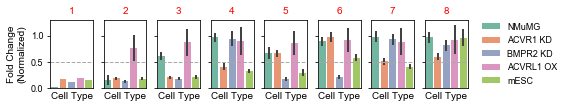

In [32]:
fig, axes = plot_channels_exp(df_norm, ligs, channel_words, thresh=thresh,
                              wspace=0.25, right=0.85)

Filter out the all-off channel as well as the penultimate channel, where one bar (ACVR1 KD) is extremely close to the chosen threshold.

In [33]:
inds_keep = [1, 2, 3, 4, 5, 7]
channel_inds_keep = channel_inds[inds_keep]
channel_words_keep = channel_words[inds_keep]

### Visualize responses of each cell type across complete ligand titration.

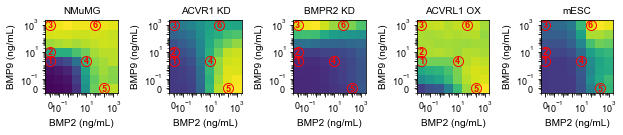

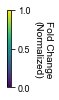

In [34]:
# Plot responses
plot_responses_exp(model_size, S_norm, titration, L[channel_inds_keep],
                   ligs, cell_types, vmin=0)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure5A.pdf'), **savefig_kwargs)

# Plot colorbar
fig, axis = plt.subplots(1, 1, figsize=(1.5, 1.5))
im = axis.imshow(np.array([[0, 1]]), cmap='viridis', vmin=0, vmax=1)
axis.set_visible(False)
cb = plt.colorbar(im, ax=axis, ticks=[0, 0.5, 1])
cb.ax.tick_params(labelsize=ticksize)
cb.set_label('Fold Change\n(Normalized)', fontsize=labelsize,
             rotation=-90, labelpad=22)
plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure5AD_colorbar.pdf'),
                **savefig_kwargs)

### Visualize responses of each cell type for each channel.

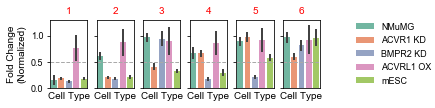

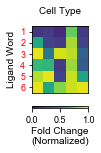

In [35]:
# Plot responses for each channel
plot_channels_exp(df_norm, ligs, channel_words_keep, thresh=thresh)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure5B.pdf'), **savefig_kwargs)

# Plot crosstalk matrix
plot_matrix_exp(S_norm[channel_inds_keep], fignum=2)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure5C.pdf'), **savefig_kwargs)

### Read in results for _in vitro_ addressing by BMP9 and BMP10.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [36]:
data_dir = os.path.join('..', 'Data')
data_file = 'Figure5_BMP9-BMP10.csv'

# Specify key parameters
ligs = ['BMP9', 'BMP10']
cell_types = ['NMuMG', 'ACVR1 KD', 'BMPR2 KD']
model_size = (2, 4, 3)
L_min, L_max, L_res = -5/3, 3, 8
L = psb.titrate_ligand(2, L_min, L_max, L_res)

# Read in results for experimental addressing
df = pd.read_csv(os.path.join(data_dir, data_file))

Process data and binarize matrix with threshold of 0.5 to identify unique channels.

In [37]:
# Process data
df_norm, S_norm, titration = process_data_exp(df, ligs, cell_types)

# Threshold data
thresh = 0.5
S_thresh = (S_norm >= thresh)

# Identify unique channels
channels, index, inv = \
    np.unique(S_thresh, axis=0, return_index=True, return_inverse=True)

Identify representative ligand word for each channel. Some channels may have only one associated ligand word, which can set constraints on the worst on- and off-target values. Therefore, picking words for other channels should be done so as to minimize any worsening of those values as well as to maximize distinguishability. The first pass identifies any constraints on the worst on-target and off-target values, and the second pass uses those values to make choices for those channels with multiple possible words.

In [38]:
# Do first pass to identify worst-case on-target and off-target values
worst_on = 1
worst_off = 0
for i, channel in enumerate(channels):
    # Identify ligand words associated with each channel
    inds = np.where(inv == i)[0]
    
    # Identify on-target and off-target values
    on_vals = S_norm[inds][:, channel == 1]
    off_vals = S_norm[inds][:, channel == 0]
    
    # If every cell type is on-target, identify the minimum
    # on-target value over all cell types and the maximum
    # such value over all ligand words
    if off_vals.shape[1] == 0:
        min_on = np.min(on_vals, axis=1)
        worst_on = np.minimum(worst_on, np.max(min_on))
    # If every cell type is off-target, identify the maximum
    # off-target value over all cell types and the minimum
    # such value over all ligand words
    elif on_vals.shape[1] == 0:
        max_off = np.max(off_vals, axis=1)
        worst_off = np.maximum(worst_off, np.min(max_off))
    # Otherwise, check for cases with only one possible word
    elif len(inds) == 1:
        worst_on = np.minimum(worst_on, np.min(on_vals, axis=1))
        worst_off = np.maximum(worst_off, np.max(off_vals, axis=1))

# Do second pass to identify best channels subject to constraints
channel_inds = np.zeros(len(channels)).astype(int)
channel_words = np.zeros((len(channels), L.shape[1]))
for i, channel in enumerate(channels):
    # Identify ligand words associated with each channel
    inds = np.where(inv == i)[0]
    
    # Identify on-target and off-target values
    on_vals = S_norm[inds][:, channel == 1]
    off_vals = S_norm[inds][:, channel == 0]
    
    # Analyze case where every cell type is on-target
    if off_vals.shape[1] == 0:
        min_on = np.min(on_vals, axis=1)
        channel_inds[i] = inds[np.argmax(min_on)]
    # Analyze case where every cell type is off-target
    elif on_vals.shape[1] == 0:
        max_off = np.max(off_vals, axis=1)
        channel_inds[i] = inds[np.argmin(max_off)]
    # Analyze channels with both on-target and off-target values
    else:
        min_on = np.min(on_vals, axis=1)
        max_off = np.max(off_vals, axis=1)
        disting = min_on / max_off
        
        # Check first for cases that do not alter worst
        # on-target and off-target values
        valid = (min_on > worst_on) & (max_off < worst_off)
        if sum(valid):
            channel_inds[i] = inds[valid][np.argmax(disting[valid])]
        else:
            channel_inds[i] = inds[np.argmax(disting)]
    channel_words[i] = L[channel_inds[i]]

# Set appropriate ligand concentrations for each word
channel_words[channel_words == 10 ** L_min] = 0

Visualize responses.

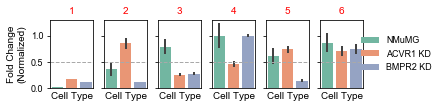

In [39]:
fig, axes = plot_channels_exp(df_norm, ligs, channel_words, thresh=thresh,
                              wspace=0.25, right=0.85)

Filter out the all-off channel.

In [40]:
inds_keep = [1, 2, 3, 4, 5]
channel_inds_keep = channel_inds[inds_keep]
channel_words_keep = channel_words[inds_keep]

### Visualize responses of each cell type across complete ligand titration.

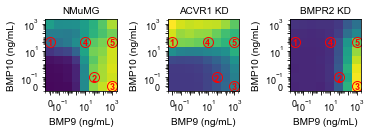

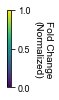

In [41]:
# Plot responses
plot_responses_exp(model_size, S_norm, titration, L[channel_inds_keep],
                   ligs, cell_types, vmin=0)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure5D.pdf'), **savefig_kwargs)

# Plot colorbar
fig, axis = plt.subplots(1, 1, figsize=(1.5, 1.5))
im = axis.imshow(np.array([[0, 1]]), cmap='viridis', vmin=0, vmax=1)
axis.set_visible(False)
cb = plt.colorbar(im, ax=axis, ticks=[0, 0.5, 1])
cb.ax.tick_params(labelsize=ticksize)
cb.set_label('Fold Change\n(Normalized)', fontsize=labelsize,
             rotation=-90, labelpad=22)
plt.tight_layout()

### Visualize responses of each cell type for each channel.

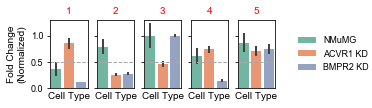

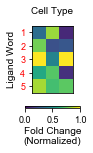

In [42]:
# Plot responses for each channel
plot_channels_exp(df_norm, ligs, channel_words_keep, thresh=thresh)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure5E.pdf'), **savefig_kwargs)

# Plot crosstalk matrix
plot_matrix_exp(S_norm[channel_inds_keep], fignum=2)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure5F.pdf'), **savefig_kwargs)

# Information theoretic analysis of addressing

## Figure 6

Define utility functions to analyze and visualize results.

In [43]:
L_min, L_max = 0, 3

def plot_responses_grid(model_size, R, K, e, L_res_sim=10, thresh=None,
                        order=None, size_scale=1.25, cmap='viridis',
                        fig=None, axes=None, out_file=None):
    # Specify labels
    ticks = 10 ** np.arange(L_min, L_max + 1)
    ticklabels = [r'$10^{{{:g}}}$'.format(l) for l in range(L_min, L_max + 1)]
    
    # Process inputs
    L_sim = psb.titrate_ligand(nL=2, L_min=-1.5, L_max=1.5, n_conc=L_res_sim)
    R = np.atleast_2d(R)
    if order is None:
        order = np.arange(len(R))
    inds_order = np.atleast_2d(order)
    rows, cols = inds_order.shape
    
    # Initialize plots
    fig, axes = plt.subplots(rows, cols,
                             figsize=(size_scale * cols, size_scale * rows),
                             squeeze=False)
    
    for i in range(rows):
        for j in range(cols):
            # Compute response
            matrix = psb.sim_S_LAB(model_size, L_sim, R[inds_order[i, j]],
                                   K=K, e=e, norm=True)
            
            # Threshold response (if specified)
            if thresh is not None:
                matrix = (matrix >= thresh)
            
            # Plot response
            psu.plot_responses(model_size, matrix,
                               L_min=L_min, L_max=L_max, L_res=L_res_sim,
                               axes=axes[i, j],
                               xticks=ticks, xlabels=ticklabels,
                               xlabels_on=(i == rows - 1),
                               yticks=ticks, ylabels=ticklabels,
                               ylabels_on=(j == 0),
                               cmap=cmap, vmax_shared=False)
            
            # Label plot
            set_minor_loc(ax=axes[i, j])
            axes[i, j].tick_params(axis='both', which='both',
                                   labelsize=ticksize)
            if i == rows - 1:
                axes[i, j].set_xlabel('Ligand 1', fontsize=labelsize)
            else:
                axes[i, j].yaxis.set_minor_formatter(NullFormatter())
            if j == 0:
                axes[i, j].set_ylabel('Ligand 2', fontsize=labelsize)
            else:
                axes[i, j].yaxis.set_minor_formatter(NullFormatter())
    
    plt.tight_layout()
    
    if out_file is not None:
        plt.savefig(out_file, **savefig_kwargs)
    
    return fig, axes

def compute_RLS_LIC(S):
    '''
    Compute relative ligand strength (RLS) and ligand interference
    coefficient (LIC) for response(s) in [S].
    '''
    S = np.atleast_2d(S)
    n = np.sqrt(S.shape[-1]).astype(int)
    
    # Find points corresponding to rims
    find_inds = np.reshape(np.arange(n ** 2), (n, n))
    rims_inds = np.concatenate((find_inds[:, -1], find_inds[-1, -2::-1]))
    rims = S[:, rims_inds]
    
    # Compute RLS and LIC
    L1 = np.minimum(rims[:, 0], rims[:, -1])
    L2 = np.maximum(rims[:, 0], rims[:, -1])
    with np.errstate(divide='ignore', invalid='ignore'):
        rls = L1 / L2
        rls[~np.isfinite(rls)] = 1
        lic_pos = L2 / np.max(rims, axis=1)
        lic_pos[~np.isfinite(lic_pos)] = 1
        lic_neg = np.min(rims, axis=1) / L1
        lic_neg[~np.isfinite(lic_neg)] = 1
        lic = lic_neg - lic_pos
    return rls, lic

def classify_behaviors(rls, lic):
    '''
    Return classifications of responses based on RLS and LIC.
    1: ratiometric (RLS < 0.2)
    2: additive (RLS > 0.8, -0.05 < LIC < 0.05)
    3: imbalance (RLS > 0.8, LIC < -0.1)
    4: balance (RLS > 0.8, LIC > 0.1)
    0: indeterminate
    '''
    classes = np.zeros(len(rls))
    classes[rls < 0.2] = 1
    classes[(rls > 0.8) & (np.abs(lic) < 0.05)] = 2
    classes[(rls > 0.8) & (lic < -0.1)] = 3
    classes[(rls > 0.8) & (lic > 0.1)] = 4
    return classes

def convert_parameter_values(params):
    '''
    Convert parameter values of 0.1 and 1 to -1 and 1 respectively.
    '''
    return 1 + 2 * np.log10(params)

def plot_correlation_binned(model_size, vals1, vals2, mi, bin_size=800,
                            title='', out_file=None):
    bins = np.arange(0, 2 ** (2 * np.product(model_size)), bin_size)
    
    # Compute mean mutual information by bin
    mi_bin = [np.mean(mi[bin_ind:bin_ind+bin_size]) for bin_ind in bins]
    
    # Compute mean correlation by bin
    corr = np.mean(vals1 * vals2, axis=1)
    corr_bin = [np.mean(corr[bin_ind:bin_ind+bin_size]) for bin_ind in bins]
    
    # Plot results
    plt.figure(figsize=(2.25, 2))
    plt.plot(mi_bin, corr_bin, 'k.')
    
    # Label plot
    plt.tick_params(axis='both', labelsize=ticksize)
    plt.xlabel('Mean Mutual Information', fontsize=labelsize)
    plt.ylabel('Mean Correlation', fontsize=labelsize)
    plt.title(title, fontsize=labelsize)
    
    plt.tight_layout()
    
    if out_file is not None:
        plt.savefig(out_file, **savefig_kwargs)

### Read in results for analysis of information capacity in systematically sampled parameters.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [44]:
data_dir = os.path.join('..', 'Data')
data_file = 'Figure6_lattice-sampling.pkl'

# Read in results for information theoretic analysis
with open(os.path.join(data_dir, data_file), 'rb') as f:
    model_size, lig_words, cell_types = pickle.load(f)
    nL, nA, nB = model_size
    nT = nL * nA * nB
    K_all, e_all, sigma_sq, MI_all = pickle.load(f)
    distinct, defined, classes = pickle.load(f)
    K_sort, e_sort, opt_Ke = pickle.load(f)
    inds_sort = np.argsort(MI_all.flatten())
    MI_sort = MI_all.flatten()[inds_sort]

### Read in results for analysis of parameter relationships using generative model.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [45]:
data_dir = os.path.join('..', 'Data')
data_file = 'Figure6_generative-model.pkl'

# Read in results for generative model
with open(os.path.join(data_dir, data_file), 'rb') as f:
    _, selection_pressures = pickle.load(f)
    selection_pressures = np.array(selection_pressures)
    Ke_generative, MI_generative = pickle.load(f)

### Illustrate approach with example response matrices.

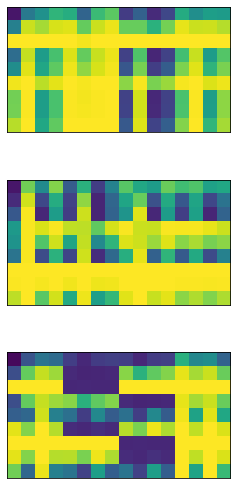

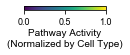

In [46]:
percentiles = [25, 50, 100]

fig, axes = plt.subplots(len(percentiles), 1,
                         figsize=(4, 3 * len(percentiles)))

# Analyze parameter sets at chosen percentiles of mutual information
for i, percentile in enumerate(percentiles):
    ind = np.round(len(MI_sort) * percentile / 100).astype(int)
    ind = np.minimum(ind, len(MI_sort) - 1)
    
    # Plot response matrix
    resp_mat = psi.sim_resp_mat(model_size, lig_words, cell_types,
                                K_sort[ind], e_sort[ind])
    plt.sca(axes[i])
    plt.matshow(resp_mat, fignum=0, vmin=0, vmax=1)
    axes[i].tick_params(axis='both', top=False, labeltop=False, bottom=False,
                        left=False, labelleft=False)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6A.pdf'), **savefig_kwargs)

# Plot colorbar
fig, axis = plt.subplots(1, 1, figsize=(3, 0.5))
im = axis.imshow(np.array([[0, 1]]), cmap='viridis', vmin=0, vmax=1)
axis.set_visible(False)
cb = plt.colorbar(im, ax=axis, ticks=[0, 0.5, 1], orientation='horizontal')
cb.ax.tick_params(labelsize=ticksize)
cb.set_label('Pathway Activity\n(Normalized by Cell Type)',
             fontsize=labelsize, rotation=0, labelpad=2)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6A_colorbar.pdf'),
                **savefig_kwargs)

### Visualize distribution of mutual information.

Highest (optimized): 2.3772 bits
Highest (non-optimized): 1.9136 bits
Median: 1.3639 bits
Lowest: 0.3225 bits


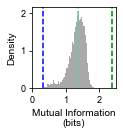

In [47]:
# Identify parameters of interest
high_K, high_e = opt_Ke[:nT], opt_Ke[nT:]
low_K, low_e = K_sort[0], e_sort[0]

# Compute corresponding response matrix and mutual information for each
high_mat = psi.sim_resp_mat(model_size, lig_words, cell_types, high_K, high_e)
low_mat = psi.sim_resp_mat(model_size, lig_words, cell_types, low_K, low_e)
high_MI = psi.MI_from_responses(high_mat, sigma_sq=sigma_sq)
low_MI = psi.MI_from_responses(low_mat, sigma_sq=sigma_sq)

# Show distribution of mutual information
print('Highest (optimized): {:.4f} bits'.format(high_MI))
print('Highest (non-optimized): {:.4f} bits'.format(np.max(MI_sort)))
print('Median: {:.4f} bits'.format(np.median(MI_sort)))
print('Lowest: {:.4f} bits'.format(low_MI))
plt.figure(figsize=(1.5, 1.5))
plt.hist(MI_sort, 50, color='darkgray', density=True)
plt.axvline(low_MI, color='b', ls='--')
plt.axvline(np.median(MI_sort), color='mediumaquamarine', ls='--')
plt.axvline(high_MI, color='g', ls='--')

# Label plot
plt.gca().tick_params(axis='both', labelsize=ticksize)
plt.xlim(left=0, right=2.5)
plt.xlabel('Mutual Information\n(bits)', fontsize=labelsize)
plt.ylabel('Density', fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6B.pdf'), **savefig_kwargs)

### Analyze addressability across channels for varying levels of mutual information.

Highest: [269.20465259  42.21207505  12.71562713  11.41757413   7.17625953
   6.93064543   5.53177397]
Median: [9.84566018 3.15040447 2.27043036 2.12517928 1.75420901 1.60837973
 1.02629479]
Lowest: [1.81113972 1.20672263 1.0373955  1.00187752 1.         1.
 1.        ]


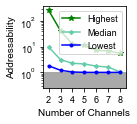

In [48]:
# Analyze addressability for each number of channels,
# ignoring trivial word with all ligand concentrations low
lig_words_filt = lig_words[1:]
b_all = np.arange(2, len(lig_words_filt) + 1)
plt.figure(figsize=(1.5, 1.5))

# Analyze parameters with highest mutual information
high_addr = psi.addressability(b_all, model_size, lig_words_filt, cell_types,
                               high_K, high_e)
print('Highest:', high_addr)
plt.plot(b_all, high_addr, 'g*-', label='Highest')

# Analyze parameters with intermediate mutual information
percentiles = [50]
colors = ['mediumaquamarine']
labels = ['Median']
for i, percentile in enumerate(percentiles):
    ind = np.round(len(MI_sort) * percentile / 100).astype(int)
    int_addr = psi.addressability(b_all, model_size, lig_words_filt,
                                  cell_types, K_sort[ind], e_sort[ind])
    print('{:s}:'.format(labels[i]), int_addr)
    plt.plot(b_all, int_addr, 'D-', color=colors[i], label=labels[i], ms=3)

# Analyze parameters with lowest mutual information
low_addr = psi.addressability(b_all, model_size, lig_words_filt, cell_types,
                              low_K, low_e)
print('Lowest:', low_addr)
plt.plot(b_all, low_addr, 'b.-', label='Lowest')

# Annotate plot
x_min, x_max, y_min = b_all[0] - 0.5, b_all[-1] + 0.5, 0.25
plt.fill_between([x_min, x_max], y_min, 1, color='darkgray')
plt.legend(loc='upper right', fontsize=ticksize)

# Label plot
plt.xlim(x_min, x_max)
plt.xticks(b_all, fontsize=ticksize)
plt.xlabel('Number of Channels', fontsize=labelsize)
plt.yscale('log')
plt.ylim(bottom=y_min)
plt.yticks(fontsize=ticksize)
plt.ylabel('Addressability', fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6C.pdf'), **savefig_kwargs)

### Visualize responses for parameter set with lowest mutual information.

Affinities: [1. 1. 1. 1. 1. 1. 1. 1.]
Activities: [0.1 1.  0.1 0.1 0.1 1.  0.1 0.1]


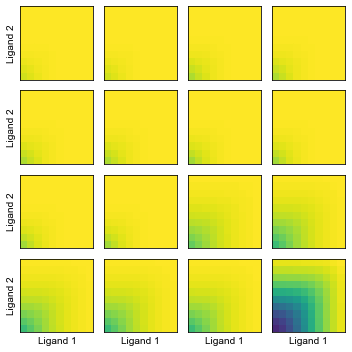

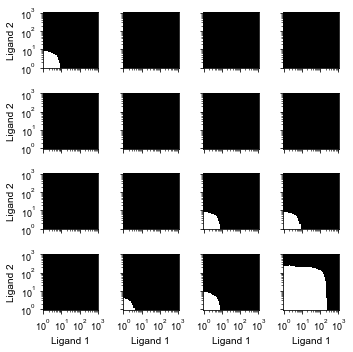

In [49]:
'''
additive: all
'''
# Print parameters
print('Affinities:', low_K)
print('Activities:', low_e)

# Plot full responses for all cell types
response_order = np.array([[12, 3, 13, 14],
                           [7, 11, 4, 8],
                           [1, 2, 15, 9],
                           [10, 5, 6, 0]])
fig, axes = plot_responses_grid(model_size, cell_types, low_K, low_e,
                                order=response_order)
for axis in axes.flatten():
    plt.sca(axis)
    axis.tick_params(axis='both', which='both',
                     bottom=False, labelbottom=False,
                     left=False, labelleft=False)
plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6D_responses.pdf'),
                **savefig_kwargs)

# Plot thresholded responses for all cell types
# (with four chosen examples on bottom row)
response_order = np.array([[6, 3, 13, 14],
                           [7, 11, 4, 8],
                           [1, 2, 5, 9],
                           [12, 15, 10, 0]])
fig, axes = plot_responses_grid(model_size, cell_types, low_K, low_e,
                                L_res_sim=50, thresh=0.85,
                                order=response_order, cmap='Greys')

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6D_thresholded.pdf'),
                **savefig_kwargs)

### Visualize responses for parameter set with highest mutual information.

Affinities: [0.99998359 0.001      0.05199762 0.00839683 0.01157293 0.01614777
 0.99610656 0.001     ]
Activities: [0.001      0.001      0.93423287 0.93236985 0.95647961 0.87553686
 0.001      0.02099066]


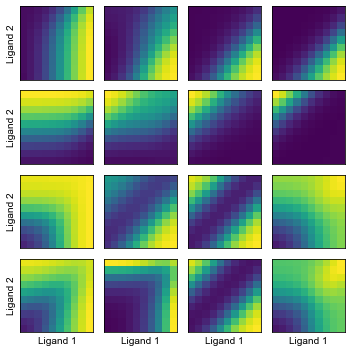

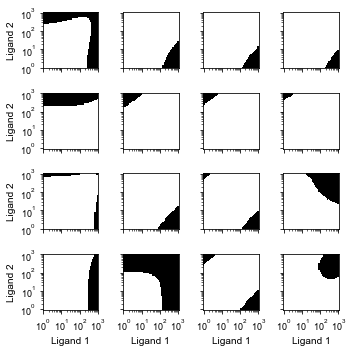

In [50]:
'''
ratiometric: 4, 5, 6, 7, 8, 9, 10, 11
additive: 12, 15
imbalance: 0, 2, 3
balance: 1, 13
indeterminate: 14 (RLS, LIC of 0.54, -0.61)
'''
# Print parameters
print('Affinities:', high_K)
print('Activities:', high_e)

# Plot full responses for all cell types
response_order = np.array([[5, 4, 7, 6],
                           [9, 8, 11, 10],
                           [12, 14, 3, 13],
                           [15, 0, 2, 1]])
fig, axes = plot_responses_grid(model_size, cell_types, high_K, high_e,
                                order=response_order)
for axis in axes.flatten():
    plt.sca(axis)
    axis.tick_params(axis='both', which='both',
                     bottom=False, labelbottom=False,
                     left=False, labelleft=False)
plt.tight_layout()

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6E_responses.pdf'),
                **savefig_kwargs)

# Plot thresholded responses for all cell types
# (with four chosen examples on bottom row)
response_order = np.array([[15, 4, 7, 6],
                           [9, 8, 11, 10],
                           [0, 14, 2, 13],
                           [5, 12, 3, 1]])
fig, axes = plot_responses_grid(model_size, cell_types, high_K, high_e,
                                L_res_sim=50, thresh=0.85,
                                order=response_order, cmap='Greys')

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6E_thresholded.pdf'),
                **savefig_kwargs)

### Analyze relationship between number of distinct archetypal responses and mutual information.

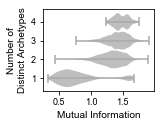

In [51]:
# Sort results by increasing mutual information
n_distinct_sort = distinct[inds_sort]
n_defined_sort = defined[inds_sort]
classes_sort = [classes[ind] for ind in inds_sort]

# Find distributions of mutual information for each number of archetypes
n_archetypes = np.unique(n_distinct_sort)
MI_archetypes = [[] for i in range(len(n_archetypes))]
for i, n in enumerate(n_archetypes):
    MI_archetypes[i] = MI_sort[n_distinct_sort == n]

# Plot distributions of mutual information for each number of archetypes
plt.figure(figsize=(2, 1.5))
violin_parts = plt.violinplot(MI_archetypes, vert=False, widths=0.95)
for part in ['cmins', 'cmaxes', 'cbars']:
    violin_parts[part].set_edgecolor('darkgray')
for body in violin_parts['bodies']:
    body.set_facecolor('darkgray')
    body.set_alpha(0.75)

# Label plot
plt.tick_params(axis='both', labelsize=ticksize)
plt.xlabel('Mutual Information', fontsize=labelsize)
plt.yticks(n_archetypes)
plt.ylabel('Number of\nDistinct Archetypes', fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6F.pdf'), **savefig_kwargs)

### Analyze relationship between specified parameter correlations and mutual information.

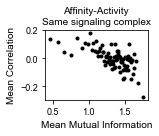

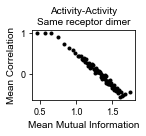

In [52]:
# Convert parameter values to allow correlation calculations
K_sort_convert = convert_parameter_values(K_sort)
e_sort_convert = convert_parameter_values(e_sort)

# Plot relationships for correlations of interest
if save_fig:
    out_file = os.path.join(out_dir, 'Figure6G.pdf')
else:
    out_file = None
plot_correlation_binned(model_size, K_sort_convert, e_sort_convert, MI_sort,
                        title='Affinity-Activity\nSame signaling complex',
                        out_file=out_file)
if save_fig:
    out_file = os.path.join(out_dir, 'Figure6H.pdf')
else:
    out_file = None
plot_correlation_binned(model_size, e_sort_convert,
                        np.roll(e_sort_convert, nA*nB, axis=1), MI_sort,
                        title='Activity-Activity\nSame receptor dimer',
                        out_file=out_file)

### Use generative model to evaluate effect of parameter anticorrelations on mutual information.

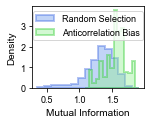

In [53]:
# Initialize plot
plt.figure(figsize=(2, 1.5))
kwargs = {'bins': 15, 'density': True}

# Plot distribution of mutual information without selection
data = np.array(MI_generative[np.where(selection_pressures == 0)[0][0]])
plt.hist(data, histtype='stepfilled', facecolor='cornflowerblue',
         edgecolor='royalblue', lw=2, alpha=0.4,
         label='Random Selection', **kwargs)

# Plot distribution of mutual information with selection
data = np.array(MI_generative[np.where(selection_pressures > 0)[0][0]])
plt.hist(data, histtype='stepfilled', facecolor='lightgreen',
         edgecolor='limegreen', lw=2, alpha=0.4,
         label='Anticorrelation Bias', **kwargs)

# Label plot
plt.legend(loc='upper center', fontsize=ticksize)
plt.tick_params(axis='both', labelsize=ticksize)
plt.xlabel('Mutual Information', fontsize=labelsize)
plt.ylabel('Density', fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'Figure6K.pdf'), **savefig_kwargs)

## Figure S6

### Read in results for analysis of information capacity in randomly sampled parameters.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [54]:
data_dir = os.path.join('..', 'Data')
data_file = 'FigureS6_random-sampling.npz'

# Read in results for information theoretic analysis
data = np.load(os.path.join(data_dir, data_file))
lig_words = data['LCombos']
cell_types = data['CTypes']
MI_all = np.log2(np.e) * data['MIlist'] + np.log2(len(lig_words))
Ke_all = data['KeList']

### Read in results for parameter estimates from experimental data.
Change `data_dir` and `data_file` as needed to specify the directory and name of the file.

In [55]:
data_dir = os.path.join('..', 'Data')
data_file = 'FigureS6_parameter-fit.csv'

# Specify key parameters
lig_labels = ['BMP4', 'BMP7', 'BMP9', 'BMP10', 'GDF5']
A_labels = ['ACVR1', 'BMPR1A']
B_labels = ['ACVR2A', 'ACVR2B', 'BMPR2']
nL, nA, nB = (len(lig_labels), len(A_labels), len(B_labels))
model_size = (nL, nA, nB)
nT = np.product(model_size)

# Read in results for parameter estimates from experimental data
data = pd.read_csv(os.path.join(data_dir, data_file), index_col=0)
K_best = np.array(data['Parameter'][:nT])
e_best = np.array(data['Parameter'][nT:(2 * nT)])

### Visualize distribution of mutual information.

Highest: 1.9033 bits
Median: 1.4216 bits
Lowest: 0.5932 bits


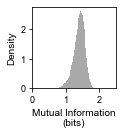

In [56]:
# Show distribution of mutual information
print('Highest: {:.4f} bits'.format(np.max(MI_all)))
print('Median: {:.4f} bits'.format(np.median(MI_all)))
print('Lowest: {:.4f} bits'.format(np.min(MI_all)))
plt.figure(figsize=(1.5, 1.5))
plt.hist(MI_all, 50, color='darkgray', density=True)

# Label plot
plt.gca().tick_params(axis='both', labelsize=ticksize)
plt.xlim(left=0, right=2.5)
plt.xlabel('Mutual Information\n(bits)', fontsize=labelsize)
plt.ylabel('Density', fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'FigureS6A.pdf'), **savefig_kwargs)

### Analyze addressability for every pair of ligands using parameters fitted to experimental data.

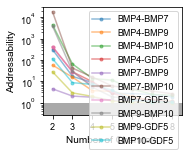

In [57]:
# Analyze all possible pairs of ligands
n_subset = 2
pairs = list(itertools.combinations(np.arange(nL), n_subset))

# Specify libraries of ligand words and cell types,
# ignoring trivial word with all ligand concentrations low
lig_words_filt = psb.titrate_ligand(n_subset, L_min=0, L_max=3, n_conc=3)[1:]
cell_types = np.array(list(itertools.product([1, 100], repeat=nA+nB)))
b_all = np.arange(2, len(lig_words_filt) + 1)
sigma_sq = 0.5

# Reshape affinity and activity parameters for convenient subset operations
K = np.reshape(K_best, model_size)
e = np.reshape(e_best, model_size)

# Initialize plot
fig = plt.figure(figsize=(2.5, 2))
major_loc = plt.LogLocator(numticks=10)
for j, pair in enumerate(pairs):
    # Analyze addressability for each number of channels
    addr = psi.addressability(b_all, (n_subset, nA, nB),
                              lig_words_filt, cell_types,
                              K[pair, :, :].flatten(),
                              e[pair, :, :].flatten())
    
    # Plot addressability for each number of channels
    plt.plot(b_all, addr, '.-', alpha=0.5,
             label='{:s}-{:s}'.format(lig_labels[pair[0]],
                                      lig_labels[pair[1]]))

# Annotate plot
x_min, x_max, y_min = b_all[0] - 0.5, b_all[-1] + 0.5, 0.25
plt.fill_between([x_min, x_max], y_min, 1, color='darkgray')
plt.legend(loc='upper right', fontsize=ticksize)

# Label plot
plt.xlim(x_min, x_max)
plt.xticks(b_all, fontsize=ticksize)
plt.xlabel('Number of Channels', fontsize=labelsize)
plt.yscale('log')
plt.ylim(bottom=y_min)
plt.gca().yaxis.set_major_locator(major_loc)
set_minor_loc(axis='y')
plt.yticks(fontsize=ticksize)
plt.ylabel('Addressability', fontsize=labelsize)

if save_fig:
    plt.savefig(os.path.join(out_dir, 'FigureS6B.pdf'), **savefig_kwargs)